# <center>Part 1</center>

**The code below up to 1.2 is taken from the TP and needs to be modified.**

# Import

In [2]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import edge_detector as ed             # A edge detector
import segment_detector as sd          # A segment detector
import edge_classifier as ec           # A edge classifier
import imgTools                        # Image tools

##   1.1. Loading and displaying OpenCV images

In [3]:
# Load a grayscale image
building = cv2.imread('image_database/Building.png')
building_color = cv2.imread('image_database/Building.png', cv2.IMREAD_COLOR)
building_gray = cv2.imread('image_database/Building.png', cv2.IMREAD_GRAYSCALE)
road_gray = cv2.imread('image_database/Road.png', cv2.IMREAD_GRAYSCALE)
road = cv2.imread('image_database/Road.png')

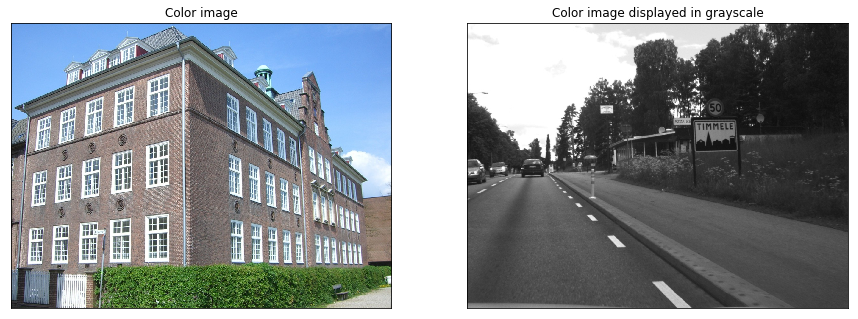

In [4]:
def display(title, img):
    imgTools.display(title, img)

def multiDisplay(titles, imgs, imgPerLine):
    imgTools.multiDisplay(titles, imgs, imgPerLine)

# Display the image
multiDisplay(['Color image', 'Color image displayed in grayscale'], [building_color, road_gray], 2)

## 1.2. Edge points extraction

### 1.2.1 Morphological Gradient of Beucher

Test different sizes of kernel. Nothing seems to be working well. The method is dropped without further research.

In [5]:
# Choose the kernel for the Gradient of Beucher
from ipywidgets import interact, fixed


def update(kSize=2):
    imgs = []
    imgsNames = ['Building gray - edges detection - Morphological Gradient of Beucher',
                 'Car gray - edges detection - Morphological Gradient of Beucher']
    for img in [building_gray, road_gray] : 
        imgEdges = ed.gradientOfBeucher(img, kSize, kSize)
        imgs.append(imgEdges)
        
    multiDisplay(imgsNames, imgs, 2)

interact(update, kSize = (0, 20, 1))

interactive(children=(IntSlider(value=2, description='kSize', max=20), Output()), _dom_classes=('widget-intera…

<function __main__.update(kSize=2)>

### 1.2.2 Non linear Laplacian

Different parameters were tested. In the end, the followings were kept : 
    - kernel size = 2 for the non linear laplacian
    - kernel size = 7 for the gaussian blur applied to the image before the laplacian to denoise the image
    - sigma = 2 for the previous gaussian blur
    

interactive(children=(IntSlider(value=2, description='kSize', max=20), IntSlider(value=7, description='kSizeB'…

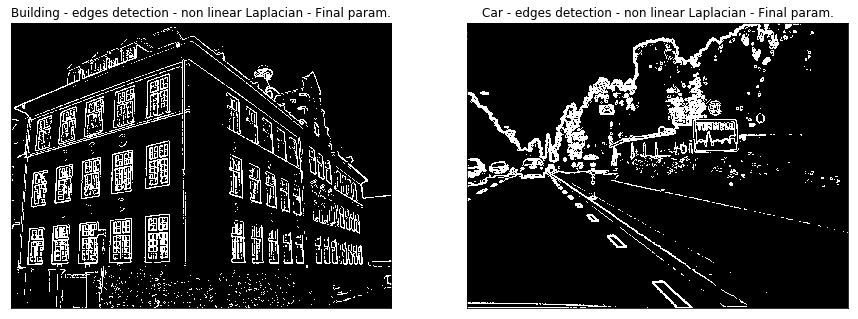

In [6]:
# Choose the parameters
from ipywidgets import interact, fixed


def update(kSize=2, kSizeB=7, sigma=2):
    imgs = []
    imgsNames = ['Building - edges detection - non linear Laplacian', 'Car - edges detection - non linear Laplacian']
    for img in [building_gray, road_gray] :
        imgBlur = cv2.GaussianBlur(img, (kSizeB, kSizeB), sigma)
        imgEdges = ed.nonLinearLaplacian(imgBlur, kernel_type=cv2.MORPH_RECT, k1=kSize, k2=kSize)
        
        med = np.mean(imgEdges)
        lo_thresh = int(2.5 * med)

        threshValue, imgThresh = cv2.threshold(imgEdges,lo_thresh,255,cv2.THRESH_BINARY)
        imgs.append(imgThresh)
        
    multiDisplay(imgsNames, imgs, 2)

interact(update, kSize = (0, 20, 1), kSizeB = (3, 20, 2), sigma = (0, 20, 1))

imgsNames = ['Building - edges detection - non linear Laplacian - Final param.',
             'Car - edges detection - non linear Laplacian - Final param.']
imgs = [ed.edgesNLL(building_gray), ed.edgesNLL(road_gray)] 
multiDisplay(imgsNames, imgs, 2)


### 1.2.3 Canny algorithm

Vanilla version (no pre-processing)

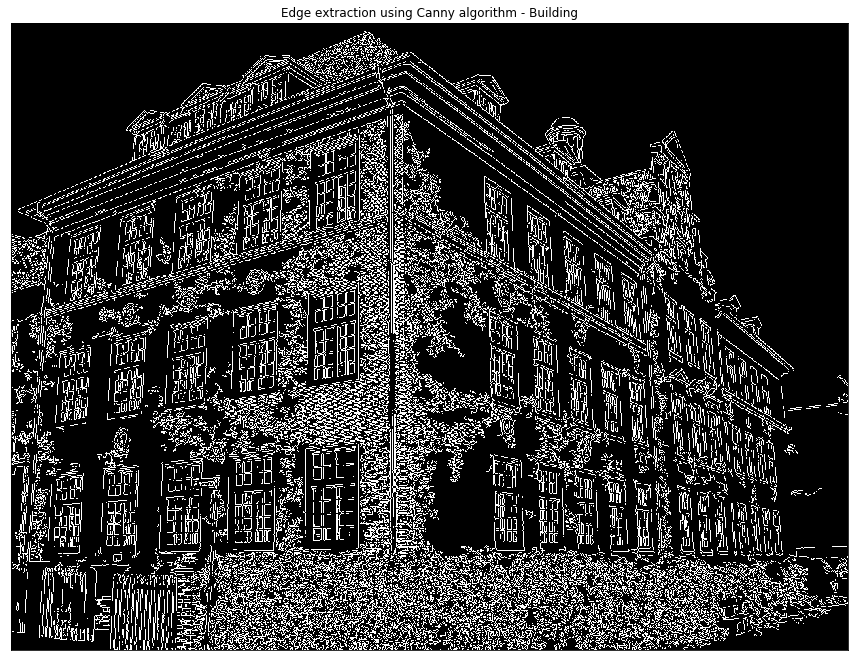

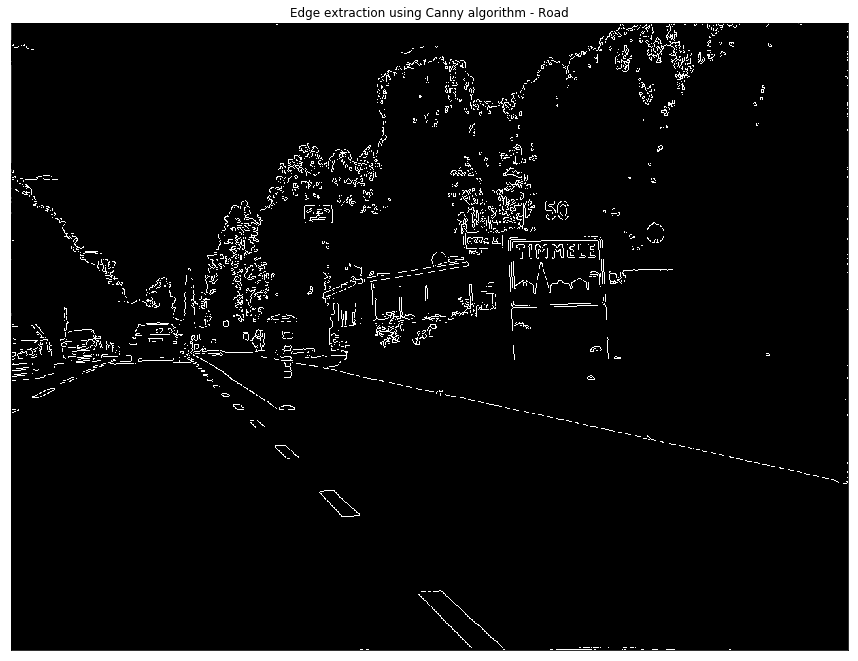

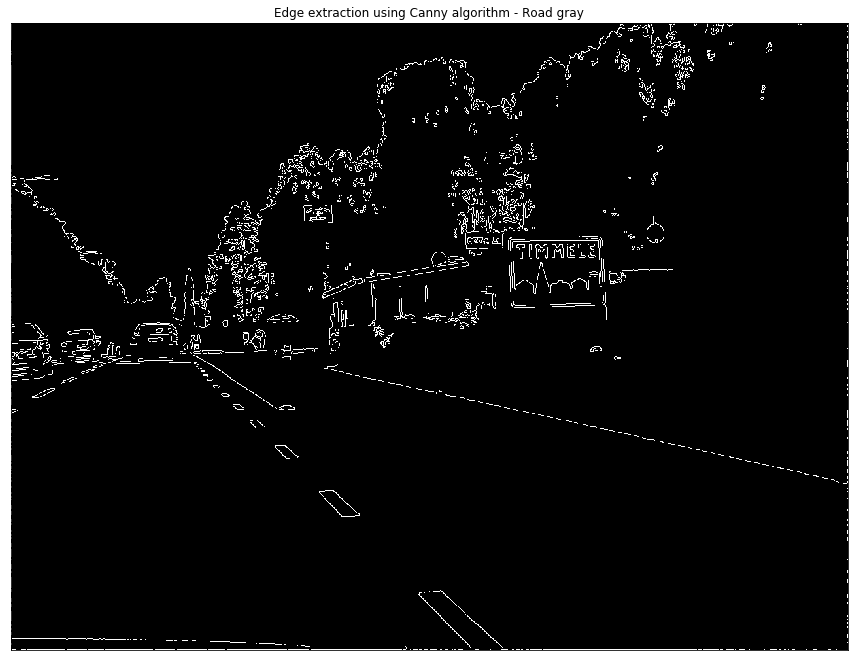

In [7]:
imgsToDetect = [building, road, road_gray]
imgsName = ["Building", "Road", "Road gray"]

for i in range(len(imgsToDetect)):
    imgEdges = ed.canny_vanilla(imgsToDetect[i])

    display('Edge extraction using Canny algorithm - '+imgsName[i], imgEdges)

With gaussian blur

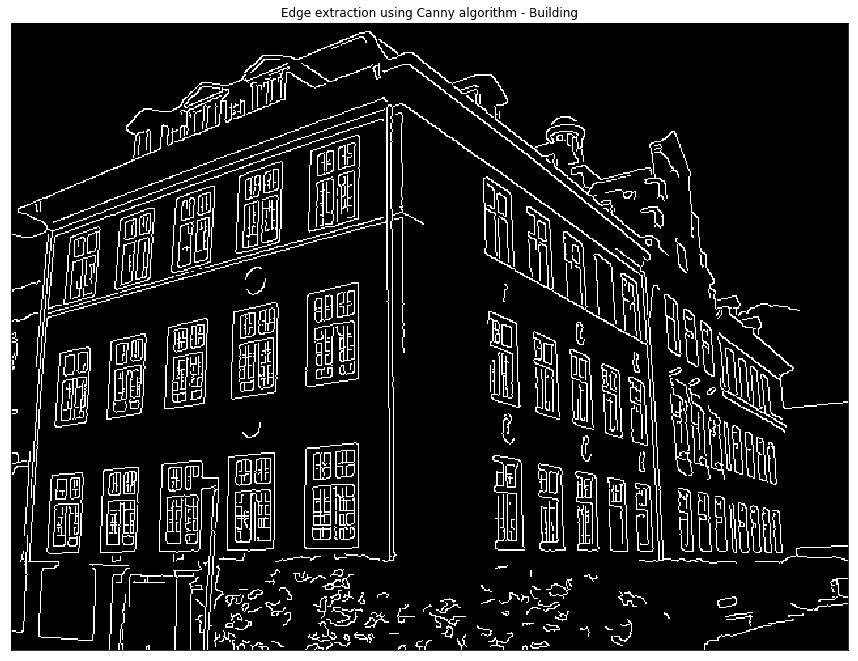

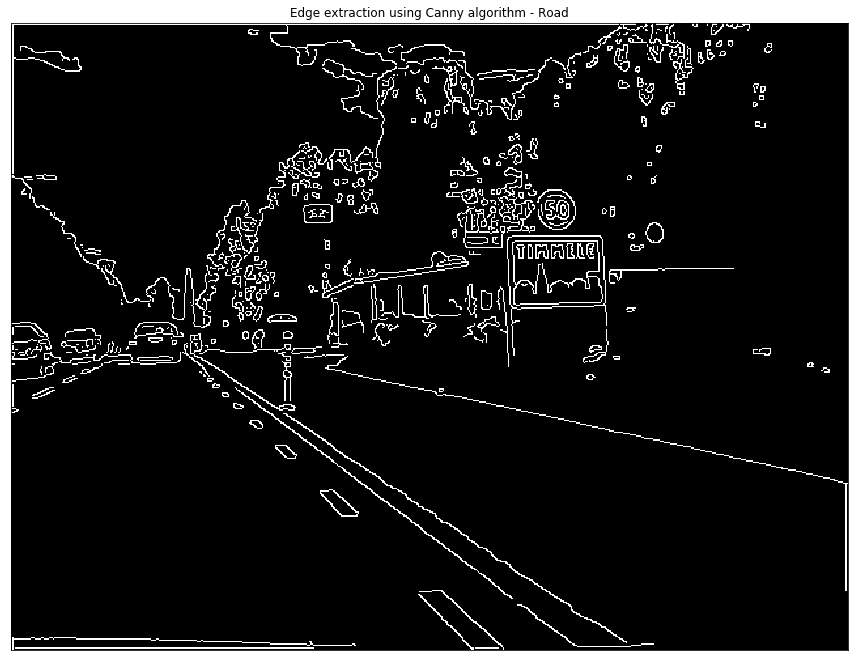

In [8]:
imgsToDetect = [building, road]
imgsName = ["Building", "Road"]

for i in range(len(imgsToDetect)):
    imgEdges = ed.canny_gaussian_blur(imgsToDetect[i])

    display('Edge extraction using Canny algorithm - '+imgsName[i], imgEdges)

With median blur

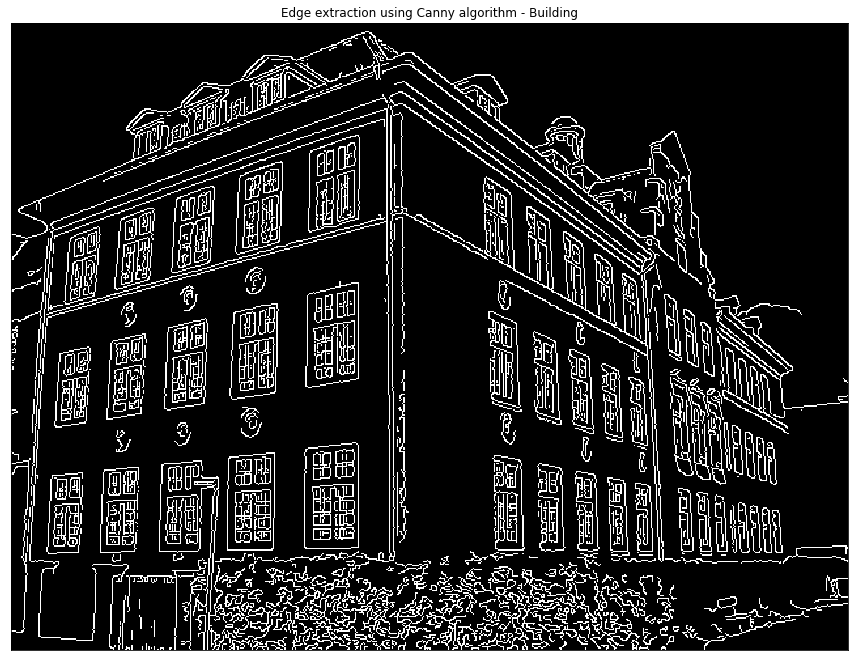

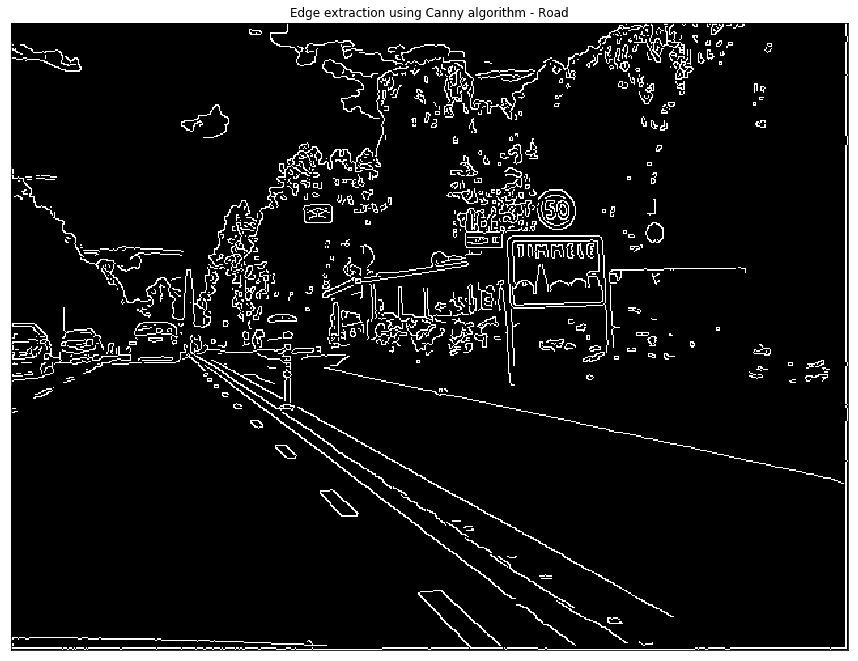

In [9]:
imgsToDetect = [building, road]
imgsName = ["Building", "Road"]

for i in range(len(imgsToDetect)):
    imgEdges = ed.canny_median_blur(imgsToDetect[i])

    display('Edge extraction using Canny algorithm - '+imgsName[i], imgEdges)

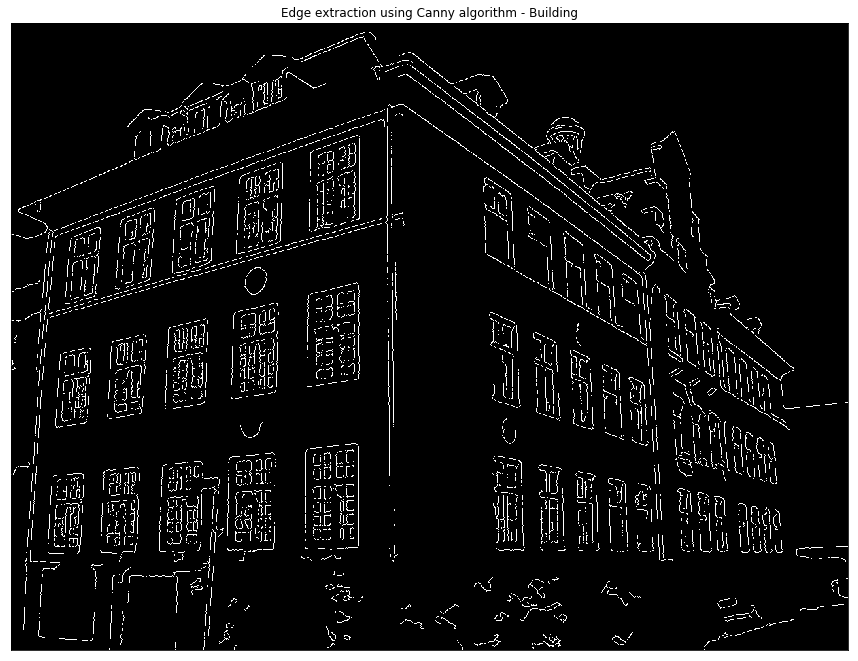

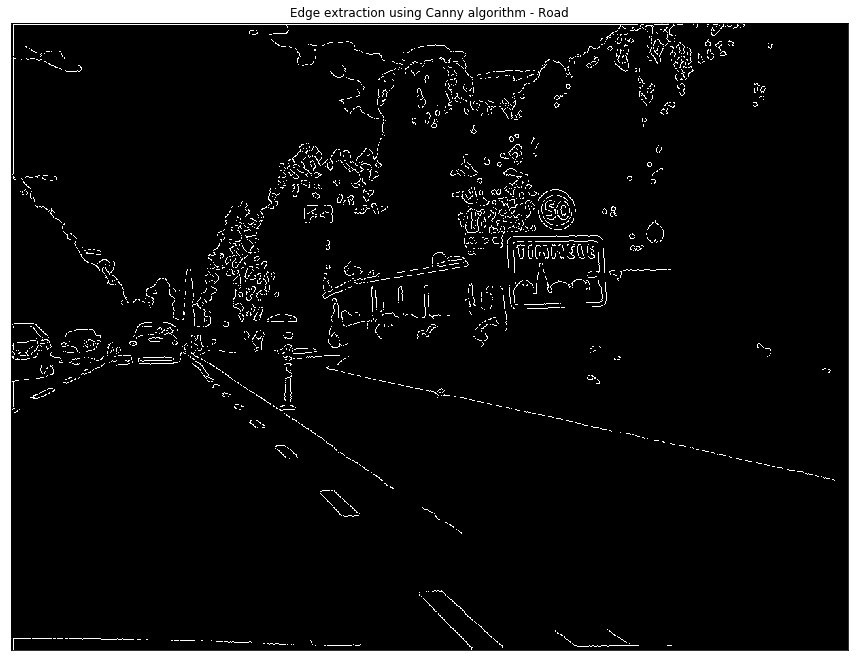

In [10]:
# Canny with less details
# Dilation can be used to thicken the edge detected


def canny_less_details(img):
    #imgEdges = ed.canny_gaussian_blur(img)
    #return imgEdges
    
    # Downsize the image
    lower_reso = cv2.pyrDown(img)
    sigma = 5
    kSize = 3
    
    # Apply gaussian blur
    lower_reso = cv2.GaussianBlur(lower_reso, (kSize,kSize), sigma)

    # Upsize the image
    higher_reso = cv2.pyrUp(lower_reso)
    
    
    # apply automatic Canny edge detection using the computed median
    med = np.median(higher_reso)
    sigma = 0
    lo_thresh = int(max(0, (1.0 - sigma) * med))
    lo_thresh = 0
    hi_thresh = int(min(255, (1.0 + sigma) * med))
        
    return cv2.Canny(higher_reso, lo_thresh, hi_thresh)

imgsToDetect = [building, road]
imgsName = ["Building", "Road"]

for i in range(len(imgsToDetect)):
    imgEdges = canny_less_details(imgsToDetect[i])

    display('Edge extraction using Canny algorithm - '+imgsName[i], imgEdges)

## 1.3. Segments and endpoints detection

### 1.3.1. Probabilistic Hough Transform

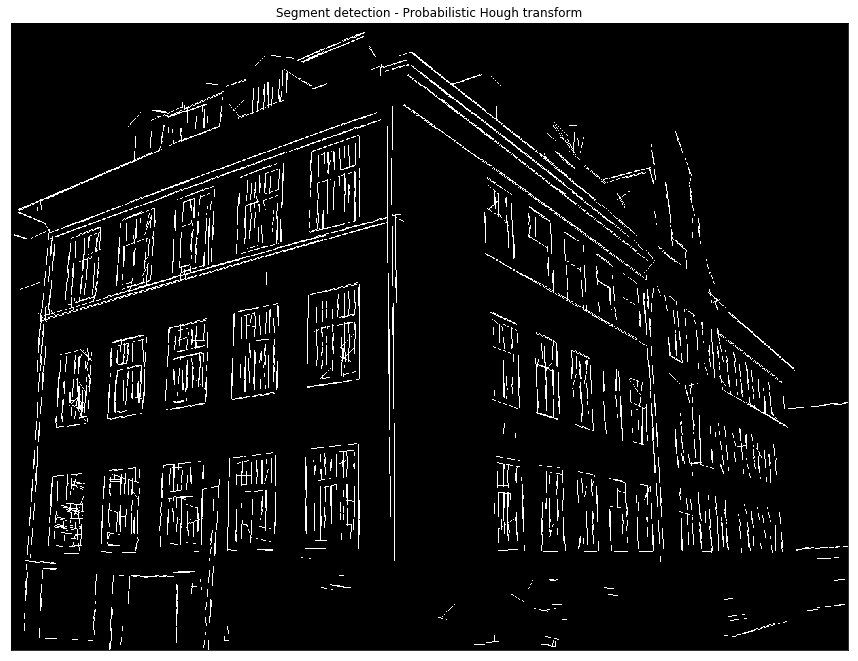

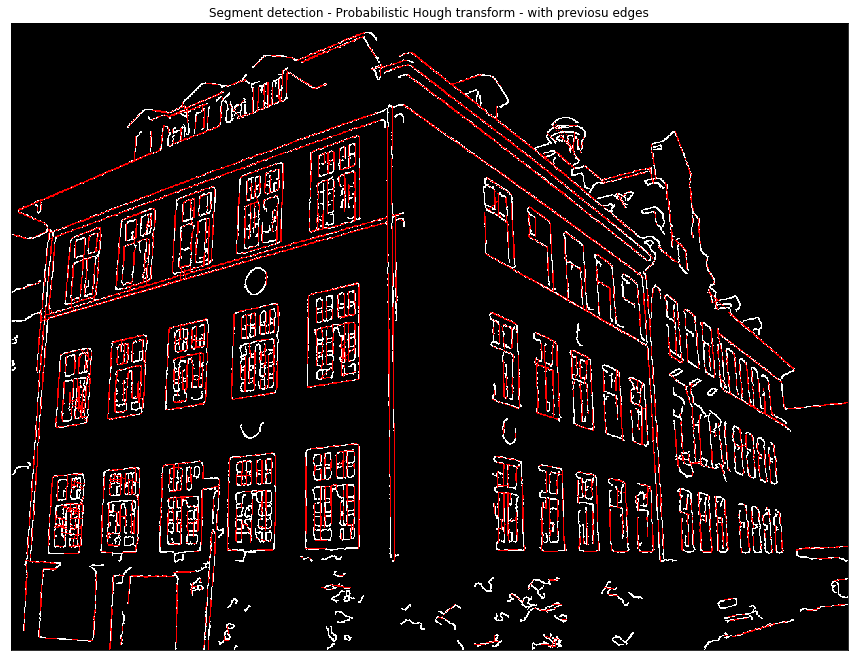

In [11]:
THRESH_VALUE = 10
def edgesDetectionFinal(img):
    #imgEdges = ed.canny_gaussian_blur(img)
    #return imgEdges
    
    # Downsize the image
    lower_reso = cv2.pyrDown(img)
    sigma = 5
    kSize = 3
    
    # Apply gaussian blur
    lower_reso = cv2.GaussianBlur(lower_reso, (kSize,kSize), sigma)

    # Upsize the image
    higher_reso = cv2.pyrUp(lower_reso)
    
    
    # apply automatic Canny edge detection using the computed median
    med = np.median(higher_reso)
    sigma = 0
    lo_thresh = int(max(0, (1.0 - sigma) * med))
    lo_thresh = 0
    hi_thresh = int(min(255, (1.0 + sigma) * med))
        
    return cv2.Canny(higher_reso, lo_thresh, hi_thresh)


# TODO change the fct for the edge detection to the one giving the best result previously
img_edges, lines, segWithEdges, seg = sd.segHough(building, edgesDetectionFinal, rho=1, theta=np.pi / 180, thresh=20, minLineLen=15,
                                       maxLineGap=4, kSize=2)
display('Segment detection - Probabilistic Hough transform', seg)
display('Segment detection - Probabilistic Hough transform - with previosu edges', segWithEdges)

In [12]:
# Test the previous one with different threshold
from ipywidgets import interact, fixed

def update(rho=1, thresh=20, minLineLen=10, maxLineGap=4, kSize=2):
    for img in [building]:#[building, road] : 
        img_edges, lines, segWithEdges, seg = sd.segHough(img, edgesDetectionFinal, rho, np.pi / 180, thresh, minLineLen,
                                        maxLineGap, kSize)
        display('Seg extraction', segWithEdges)
        display('Seg extraction without image behind', seg)

interact(update, rho = (0,10,1), thresh = (0, 50, 2), minLineLen=(0,100,5), maxLineGap=(0,20,1), kSize=(0,20,1))

interactive(children=(IntSlider(value=1, description='rho', max=10), IntSlider(value=20, description='thresh',…

<function __main__.update(rho=1, thresh=20, minLineLen=10, maxLineGap=4, kSize=2)>

### 1.3.2 Fusing adjacent segments

The segment detection used previously is not prefect. One of the imprefection lays in the fact of mutliple segments drawn close to each other to describe the same unique edge. In order to solve this problem, 'close segments' will be fused together.

The segments detected are given in the cartesian space with its two endpoints which makes it difficult to characterize the closeness of two edges. In contrast, the Hough space can easily describe the distance between two segments and fuse them if needed. Thus, the idea of the algorithm is to map the segments in a variant of the Hough space, fuse all close segments then map the segments back to the cartesian space.

#### Mapping from cartesian to a variant of the Hough space

Let's take the example of one segment described by the two points: $A = (a_v, a_h)$ and $B = (b_v, b_h)$ where $(i,j)$ is the point with $i$ in vertical value and $j$ in horizontal values and the origin is fixed at the top left corner of the image.

The Hough space will be described by 4 values : $\theta, \rho, p, d$

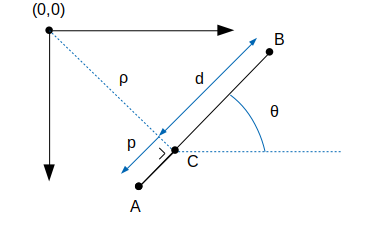

By convention, $A$ will be such that $a_h < b_h$.

**Computing $\theta$**

$$\theta = arctan \Big(\frac{|b_v - a_v|}{|b_h-a_h|} \Big)$$

Then we want to have $\theta \in ]\pi/2, \pi [$ if the slope of the line is decreasing, thus : 

$$\theta_{final} = \pi - \theta \quad \text{ if $a_v < b_v$}$$

**Computing $\rho$**

$$\rho = \frac{|| \overrightarrow{AB} \times \overrightarrow{OA} ||}{|| \overrightarrow{AB} ||}$$

$\rho$ must be lower than zero  when $c_h < 0$. However, $c_h$ has not been computed yet. Thus, the intersection between the line and $x = 0$ will be computed instead. If, this point has a horizontal value lower than 0, it means $c_h < 0$ and thus $\rho < 0$. 

$$\quad \left\{
    \begin{array}{ll}
      y = mx+n \\
      x  = 0
    \end{array}
  \right.$$ 
$$\Leftrightarrow \left\{
    \begin{array}{ll}
      y = \frac{a_h-b_h}{a_v-b_v}x+(a_h - a_v \frac{a_h-b_h}{a_v-b_v}) \\
      x  = 0
    \end{array}
  \right.$$ 
$$\Leftrightarrow \left\{
    \begin{array}{ll}
      y = a_h - a_v \frac{a_h-b_h}{a_v-b_v} \\
      x  = 0
    \end{array}
  \right.$$ 

Thus, $$\rho_{final} = - \rho \quad \text{ if $a_h - a_v \frac{a_h-b_h}{a_v-b_v} < 0$}$$


**Computing C**
$$c_v = \rho * cos(\theta)$$
$$c_h = \rho * sin(\theta)$$

**Computing $p$ and $d$**
$$p = \left\{
        \begin{array}{ll}
          -sign(c_h-a_h) * ||\overrightarrow{AC}|| & \text{ if } a_h < b_h \text{ or } (a_h = b_h \text{ & } a_v > b_v) \\
          -sign(c_h-b_h) * ||\overrightarrow{BC}|| & \text{ else }
        \end{array}
      \right.$$
$$d = ||\overrightarrow{AB}||$$


#### Mapping back from the variant of the Hough space to  the cartesian space
This action allows to go back in the cartesian space after fusing the close segments.

**Computing C**
$$c_v = \rho * cos(\theta)$$
$$c_h = \rho * sin(\theta)$$

**Computing A and B**
$$A : \left\{
        \begin{array}{ll}
          a_v =  c_v - sign(\frac{\pi}{2}-\theta) * p * sin(\theta)\\
          a_h =  c_h + sign(\frac{\pi}{2}-\theta) * p * cos(\theta)
        \end{array}
      \right.$$
$$B : \left\{
        \begin{array}{ll}
          b_v = c_v - sign(\frac{\pi}{2}-\theta) * (p+d) * sin(\theta) \\
          b_h = c_h + sign(\frac{\pi}{2}-\theta) * (p+d) * cos(\theta)
        \end{array}
      \right.$$

#### Fusing two segments
Two segments will be fused together if they fulfill the conditions below:

$$\left\{
        \begin{array}{ll}
          \Big| \theta_1-\theta_2\Big| \leq \Delta_{\theta}\\
          \Big| \rho_1-\rho_2\Big| \leq \Delta_{\rho}\\
          \Big( p_1 \leq p_2 \quad \text{ & } \quad p_1+d_1 > p_2 \Big) \text{ or }
				    \Big( p_2 \leq p_1  \quad \text{ & } \quad  p_2+d_2 > p_1 \Big)
        \end{array}
      \right.$$

The two first conditions are restricting the orientation and position of the lines extending the segments while the last one restrict the position of the segment on the line.


Then to fuse two segments, the two segments are removed and a new one is created with the following values:

$$\left\{
        \begin{array}{ll}
          \theta_n = \frac{\theta_1+\theta_2}{2}\\
          \rho_n = \frac{\rho_1+\rho_2}{2}\\
          p_n = min(p_1, p_2)\\
          d_n = max(p_1+d_1, p_2+d_2) - p_n
        \end{array}
      \right.$$



In [13]:
img_edges, lines, segWithEdge, seg = sd.segHough(building, canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                      minLineLen=15, maxLineGap=4, kSize=2)

def update(dRho=1, dTheta=1/360*np.pi*2):
    img_edges, lines2, segWithEdge2, seg2 = sd.segHough(building, canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=dTheta,
                                             dRho = dRho)
    
    multiDisplay([f"Segments with previously detected edges - {len(lines)} segments", 
                  f"Segments with previously detected edges - {len(lines2)} segments - segments fused",
                  f"Segments - {len(lines)} segments",
                  f"Segments - {len(lines2)} segments - segments fused"],
                 [segWithEdge, segWithEdge2, seg, seg2], 2)
    display(f"Segments - {len(lines2)} segments - segments fused",
             seg2)

interact(update, dRho = (0,10,1), dTheta = (1/360*np.pi*2, 20/360*np.pi*2, 1/360*np.pi*2))

interactive(children=(IntSlider(value=1, description='dRho', max=10), FloatSlider(value=0.017453292519943295, …

<function __main__.update(dRho=1, dTheta=0.017453292519943295)>

## 1.4. Segments and endpoints classification

The technique used consist in a simple matrix manipulation.
Considering $E$ a matrix of size $m*n$ representing the image containing the edges (0 if not edge, 255 if edge)
and $S$ a matrix of the same size representing the image containing the segments 
(1 if the pixel belong to as segment, 0 is not). We obtain $ES$ the matrix with all edges belonging to a segment and
 $ENS$ the matrix with all the other edges by this calculation :
 
 $ES = E.*S$ and $ENS = E .- ES$ (unitary multiplication and subtraction)
 

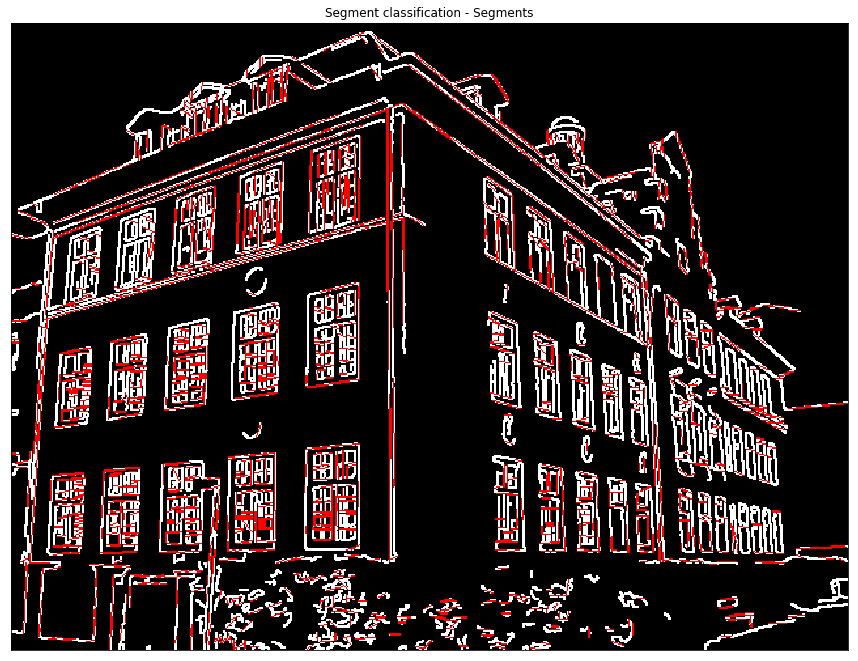

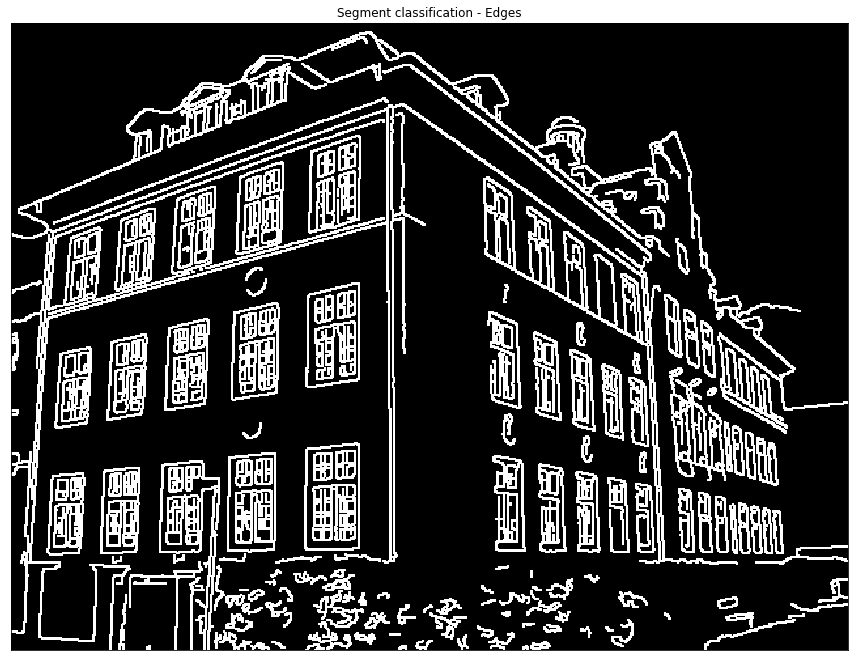

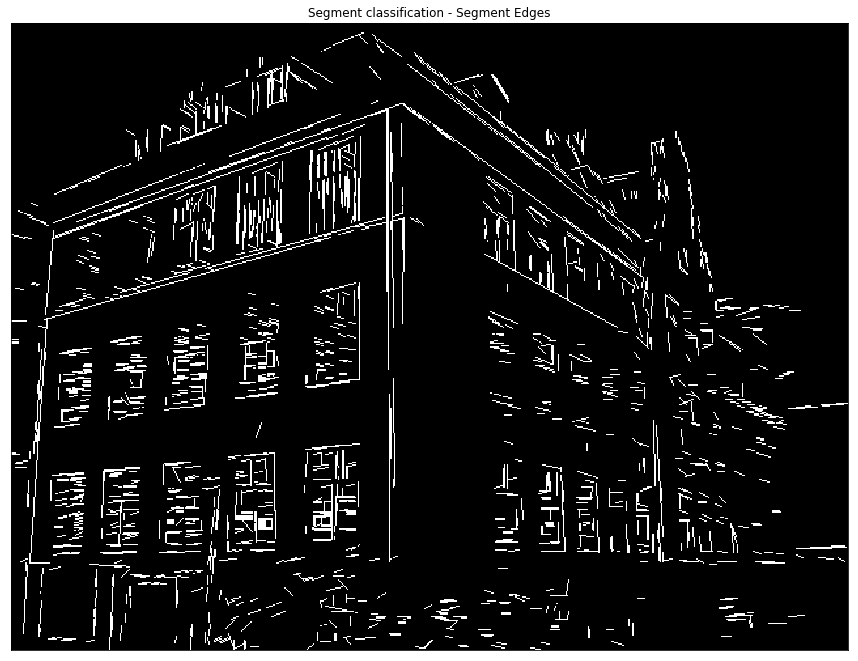

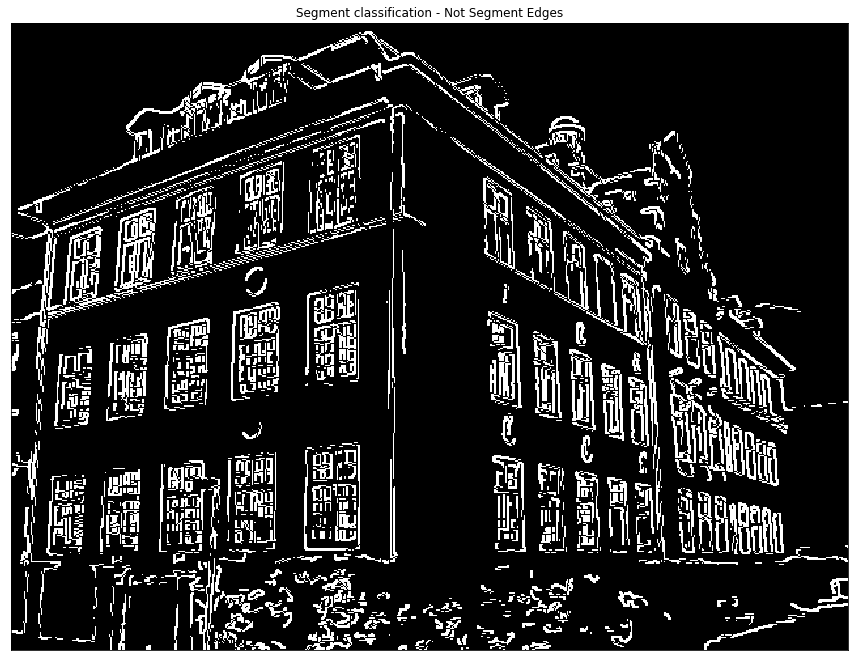

In [14]:
seg, edges, line_edges, not_line_edges = ec.edge_classifier(building)
display('Segment classification - Segments',seg)
display('Segment classification - Edges', edges)
display('Segment classification - Segment Edges', line_edges)
display('Segment classification - Not Segment Edges', not_line_edges)


## 1.5. Evaluation on databases

In [15]:
# Getting the images

import os
sudoku = []
soccer = []
road = []
pcb = []
building = []

sudokuFolder = 'image_database/sudoku'
soccerFolder = 'image_database/soccer'
roadFolder = 'image_database/road'
pcbFolder = 'image_database/pcb'
buildingFolder = 'image_database/building'

sudokuNames = sorted([img for img in os.listdir(sudokuFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in sudokuNames:
   sudoku.append(cv2.imread(sudokuFolder+'/'+name))

soccerNames = sorted([img for img in os.listdir(soccerFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in soccerNames:
   soccer.append(cv2.imread(soccerFolder+'/'+name))

roadNames = sorted([img for img in os.listdir(roadFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in roadNames:
   road.append(cv2.imread(roadFolder+'/'+name))

buildingNames = sorted([img for img in os.listdir(buildingFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in buildingNames:
   building.append(cv2.imread(buildingFolder+'/'+name))

pcbNames = sorted([img for img in os.listdir(pcbFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in pcbNames:
   pcb.append(cv2.imread(pcbFolder+'/'+name))

### 1.5.1. Sudoku

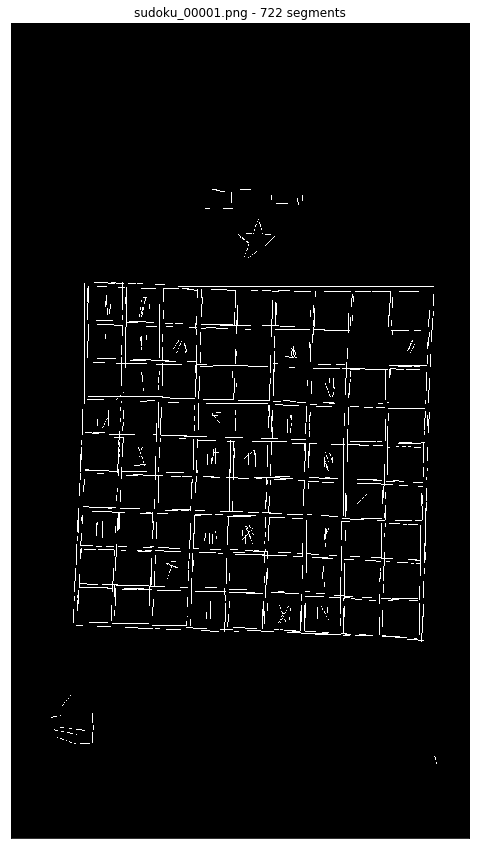

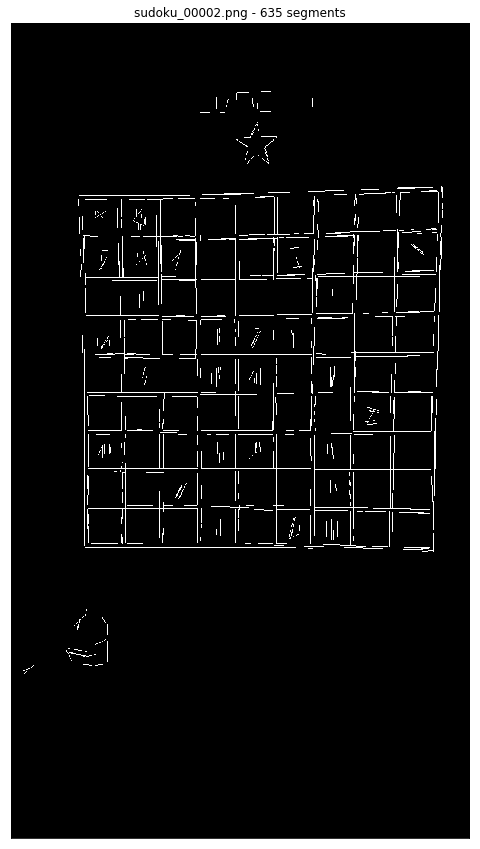

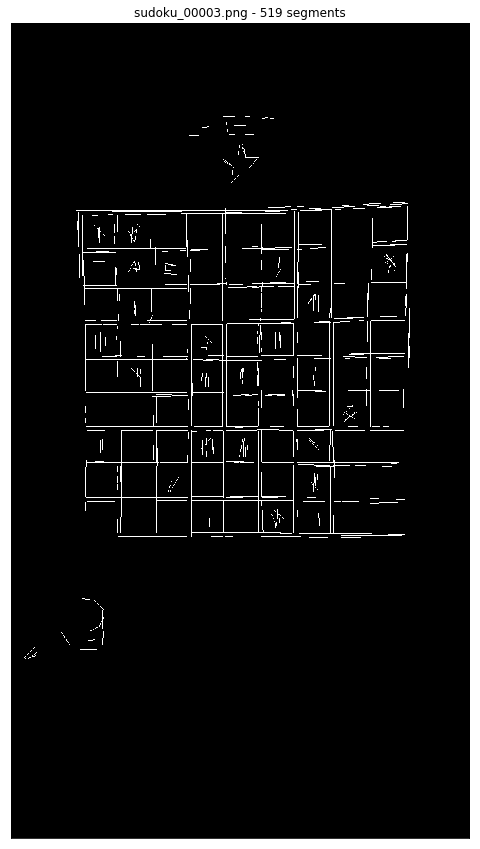

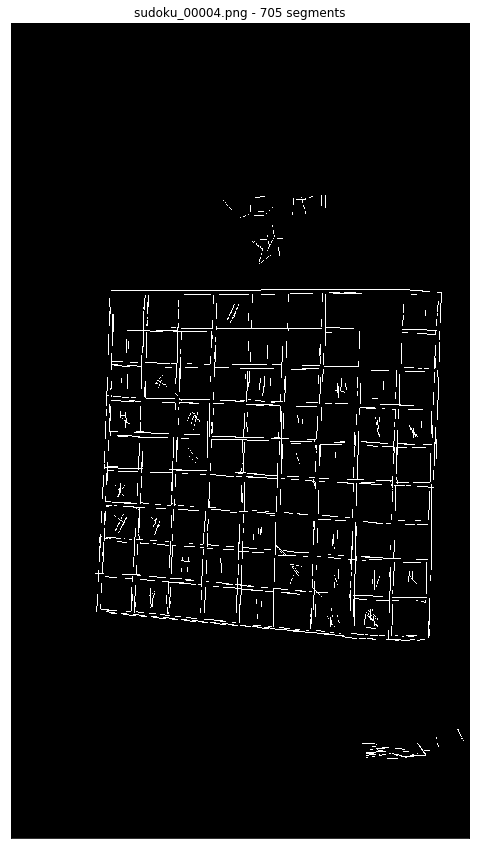

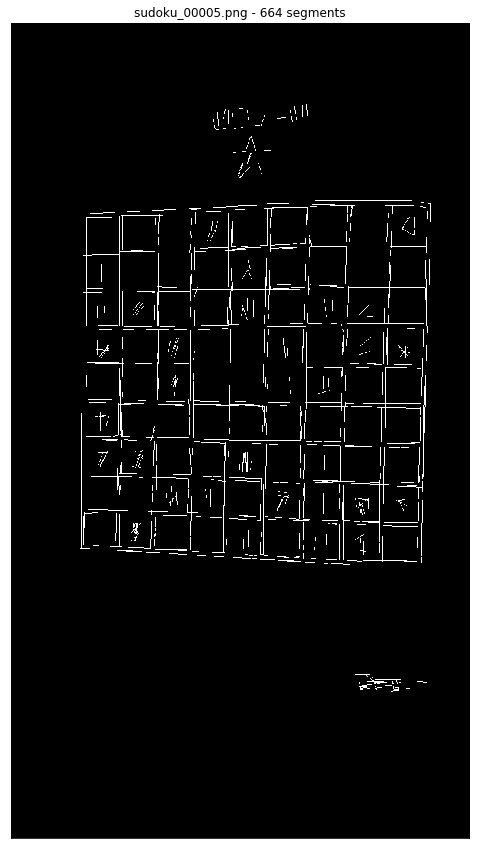

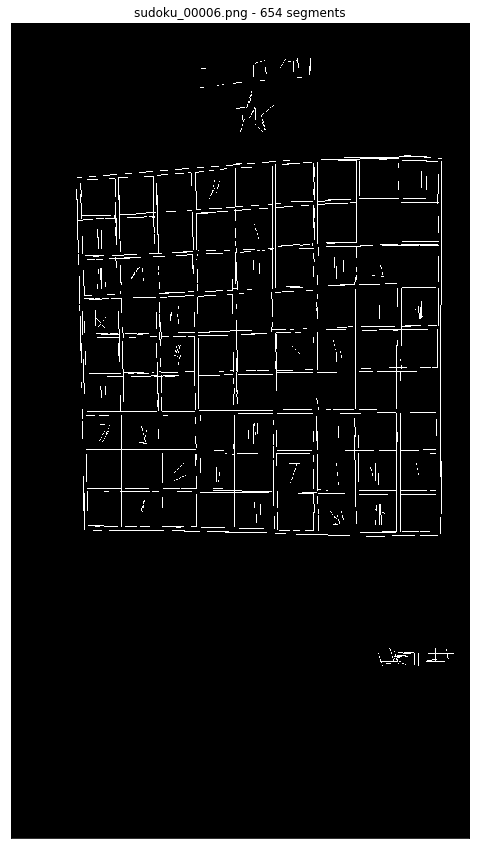

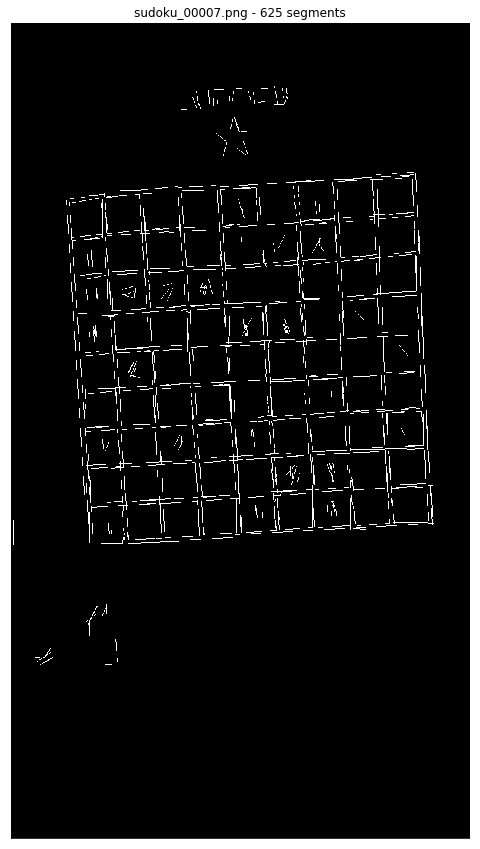

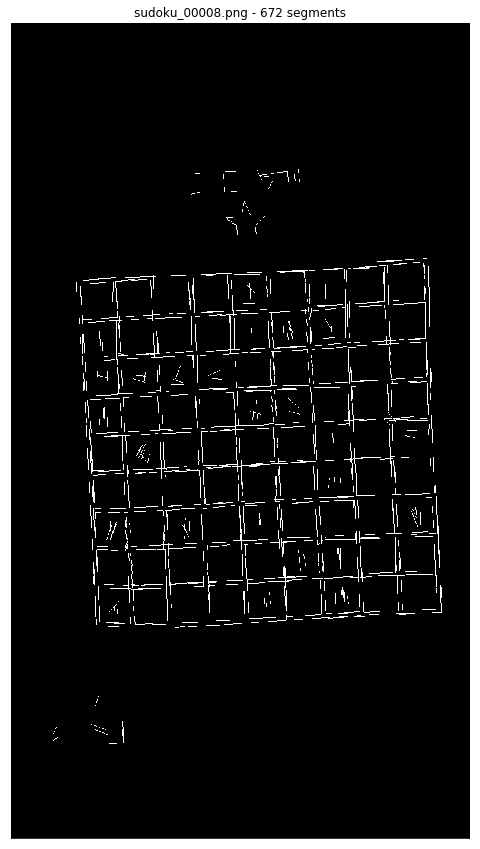

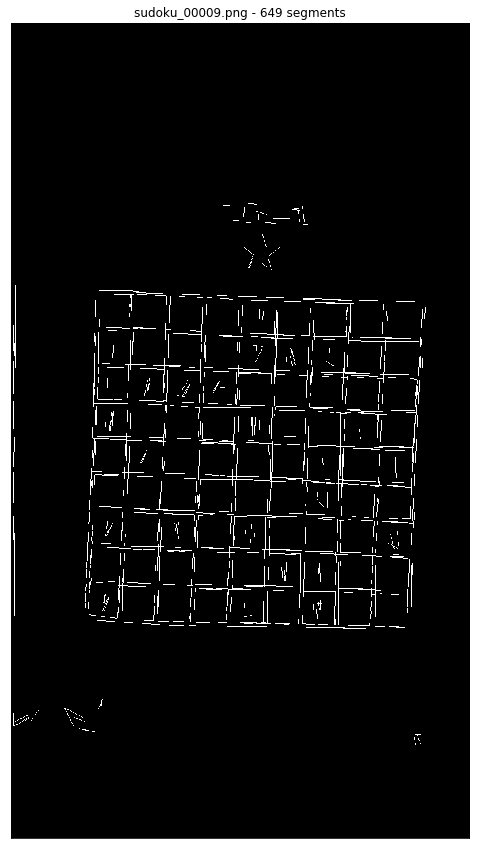

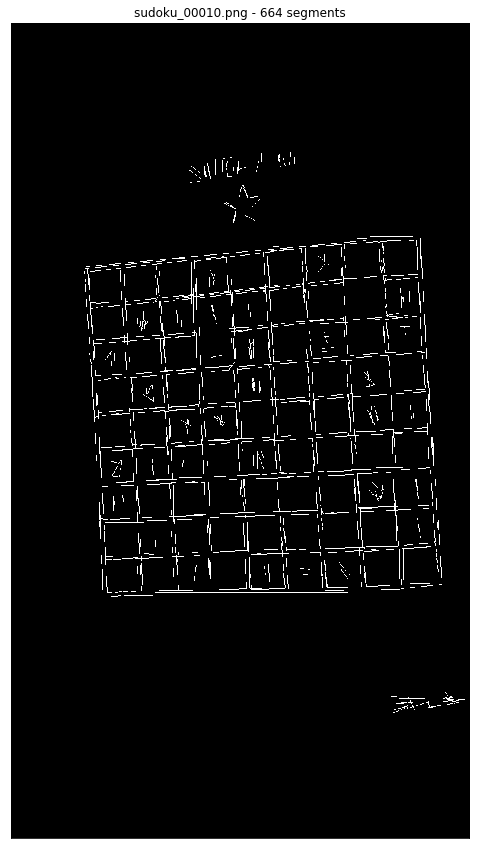

In [16]:
for i in range(10):
    img_edges, lines2, segWithEdge2, seg2 = sd.segHough(sudoku[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{sudokuNames[i]} - {len(lines2)} segments",seg2)

### 1.5.2. Soccer

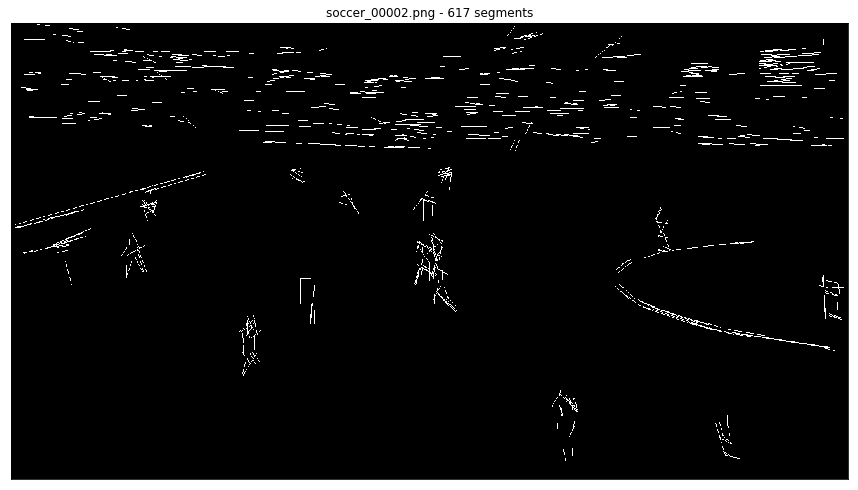

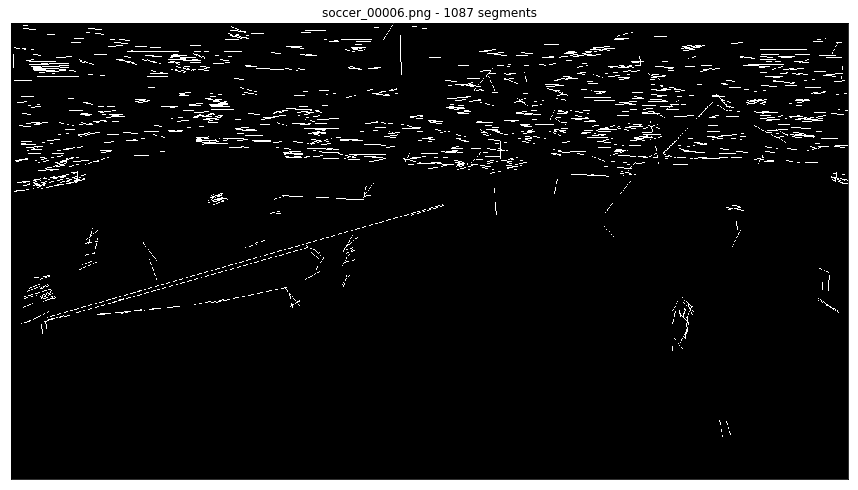

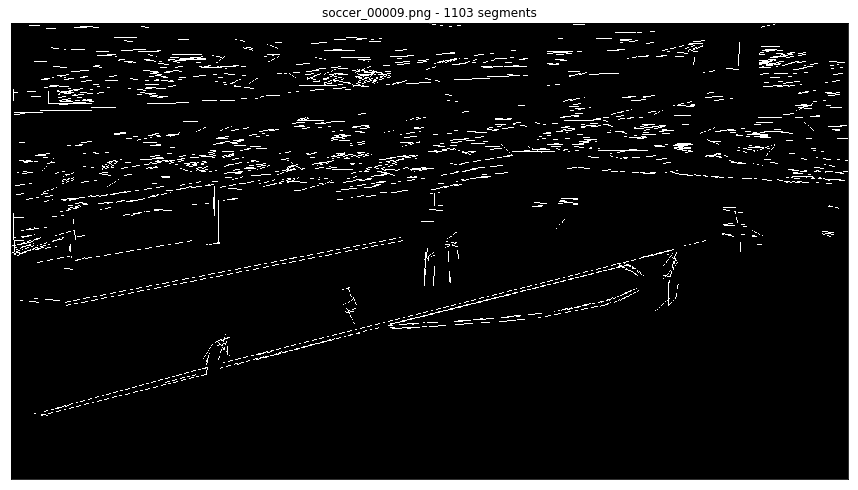

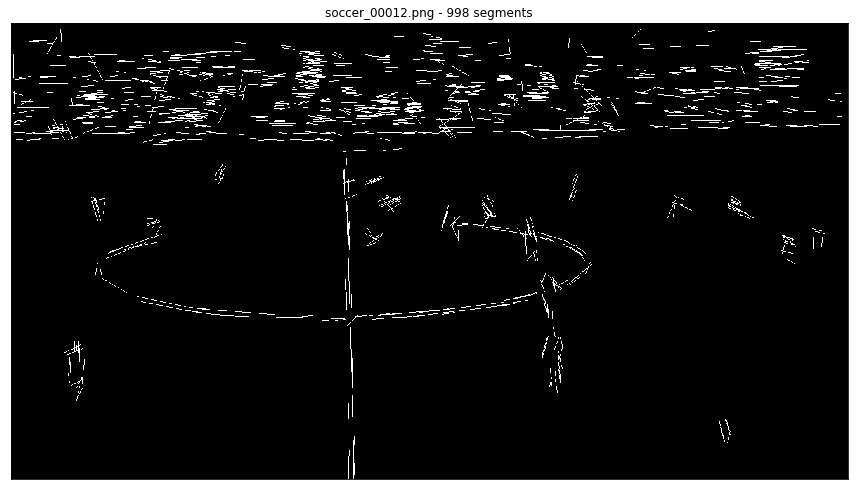

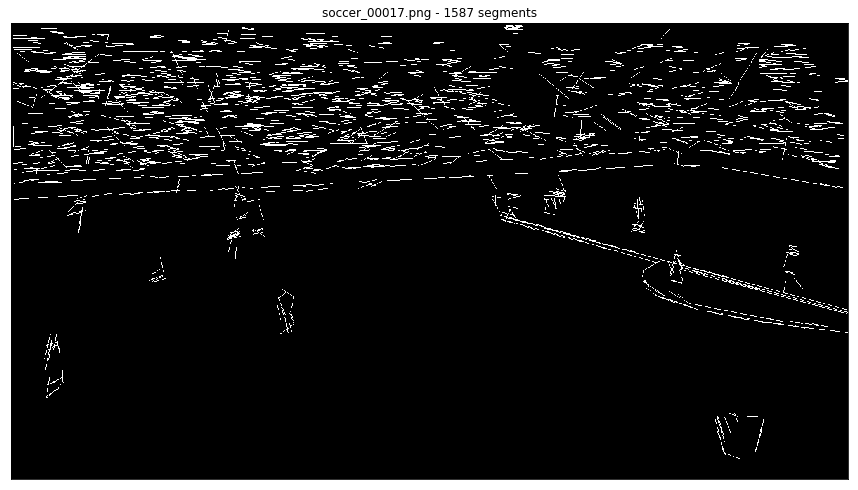

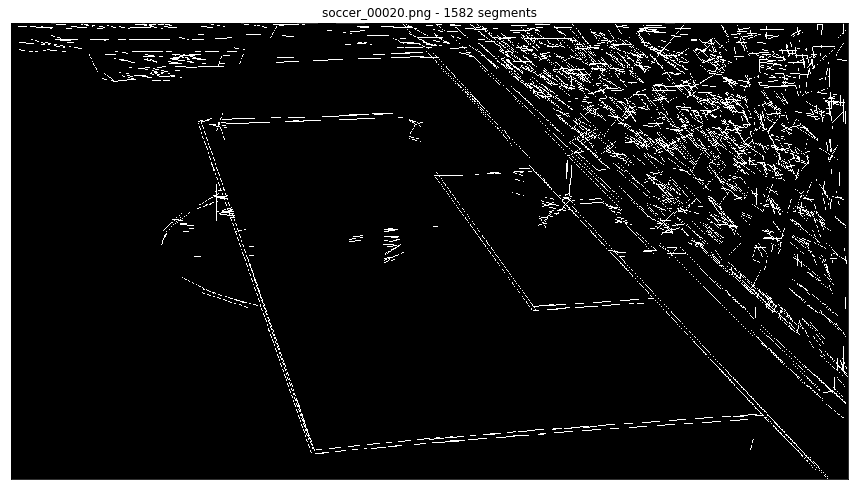

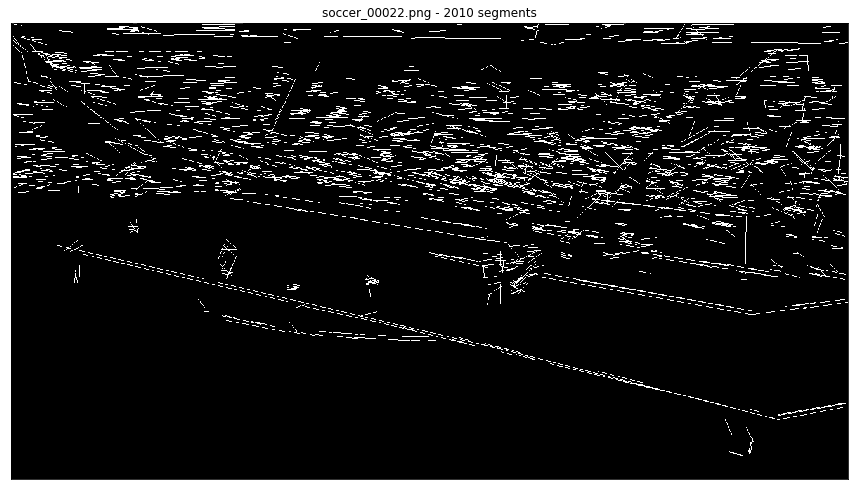

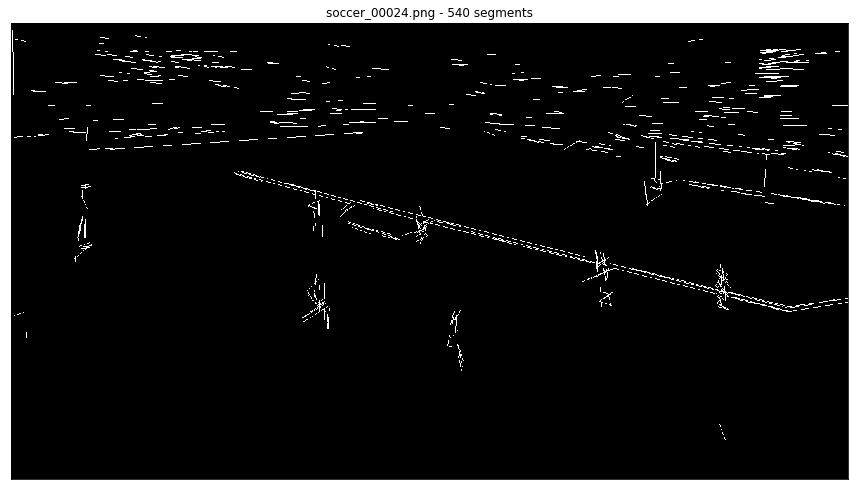

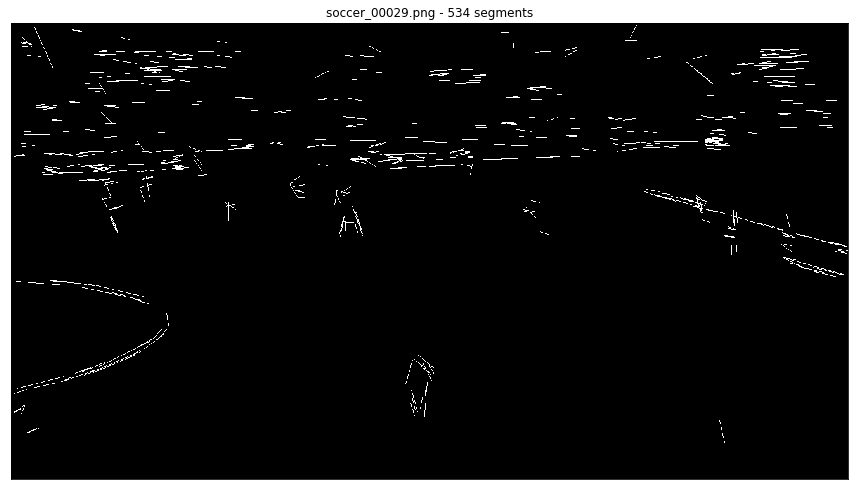

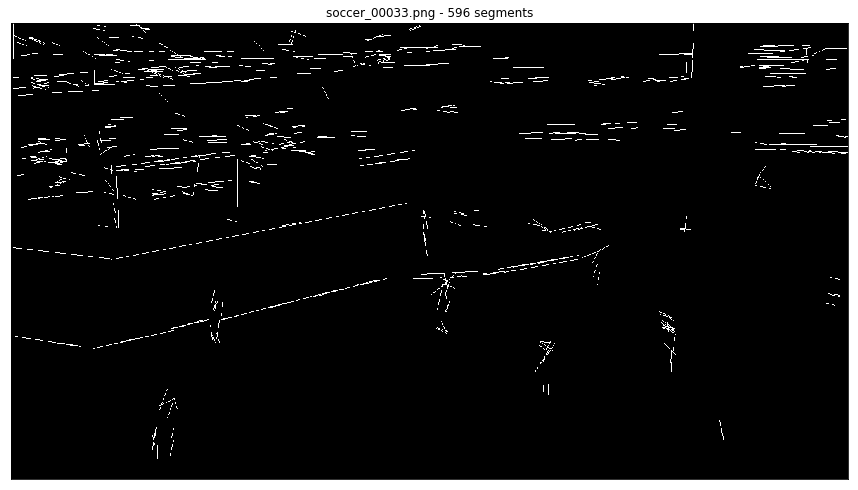

In [17]:
for i in range(10):
    img_edges, lines2, segWithEdge2, seg2 = sd.segHough(soccer[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{soccerNames[i]} - {len(lines2)} segments",seg2)

### 1.5.3. Road

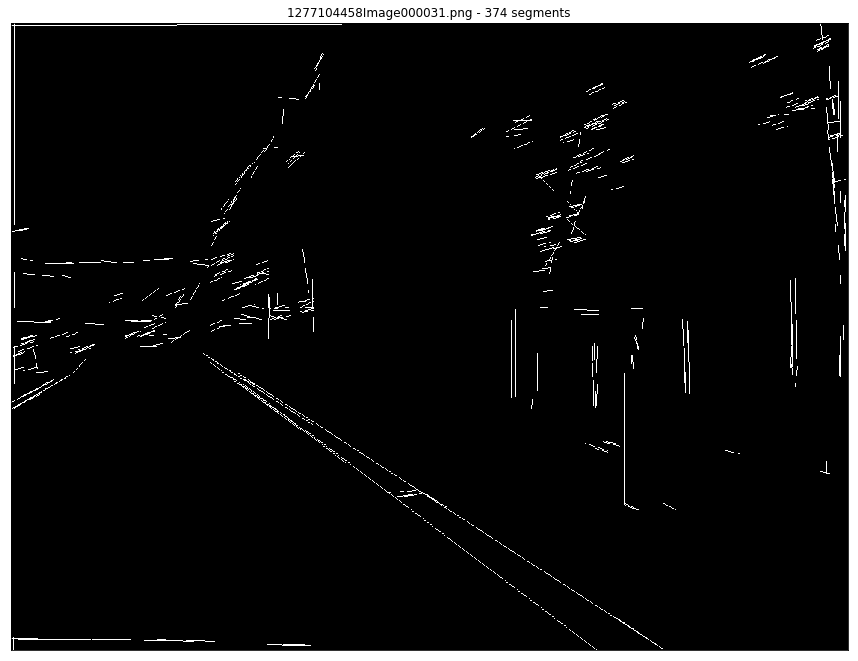

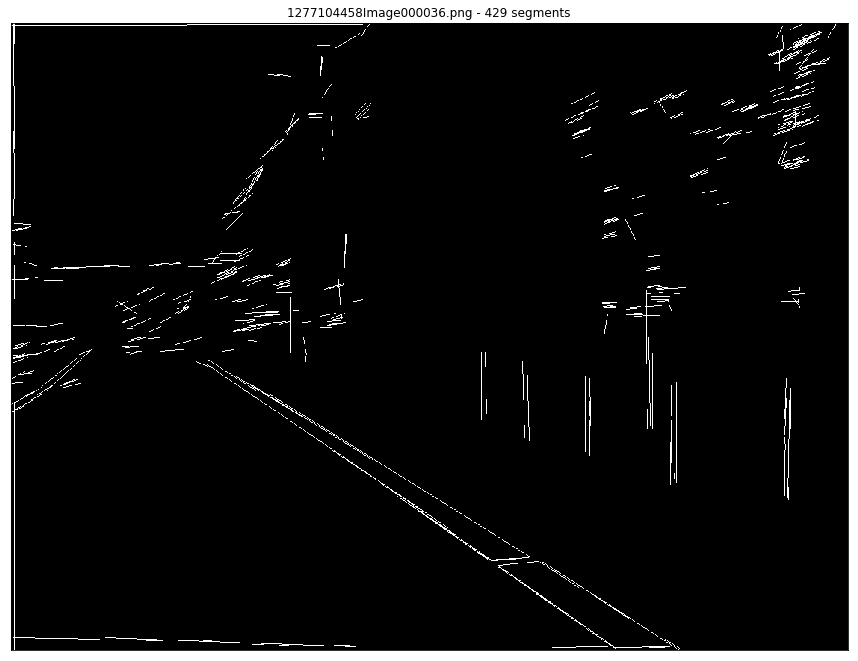

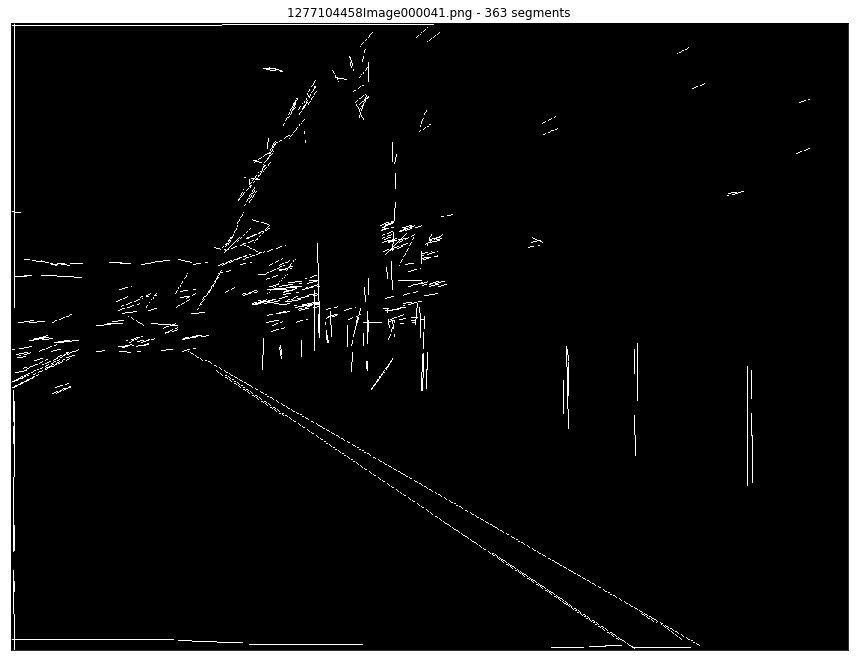

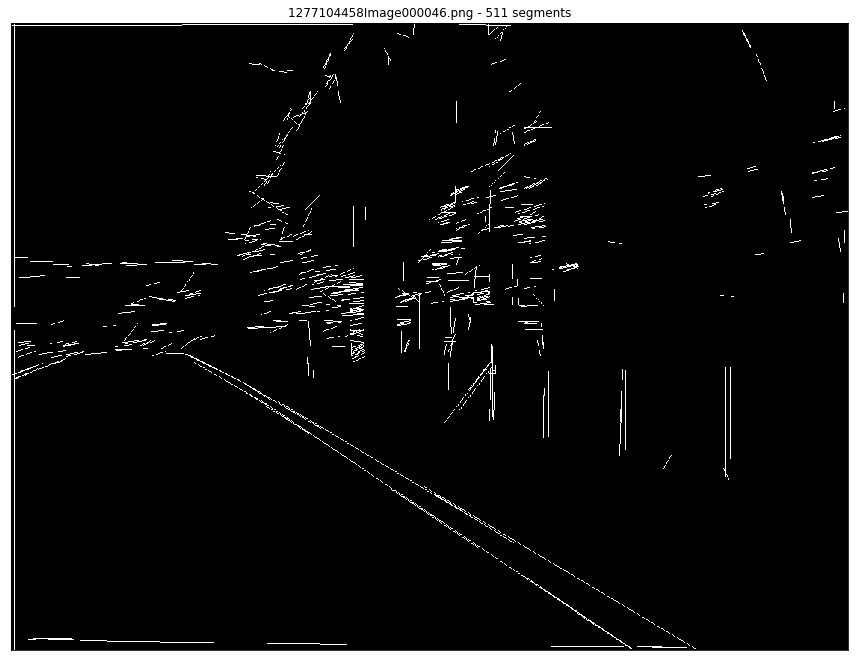

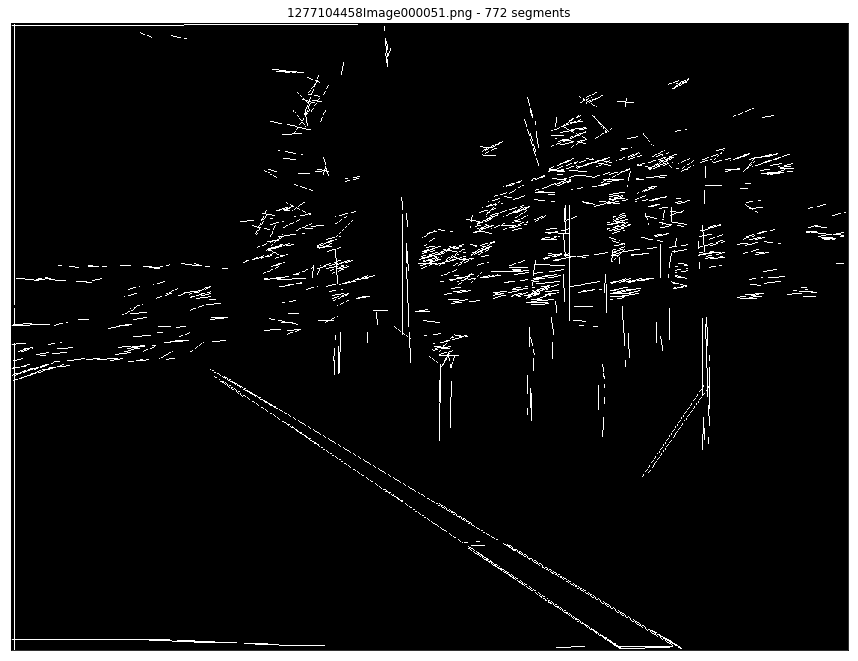

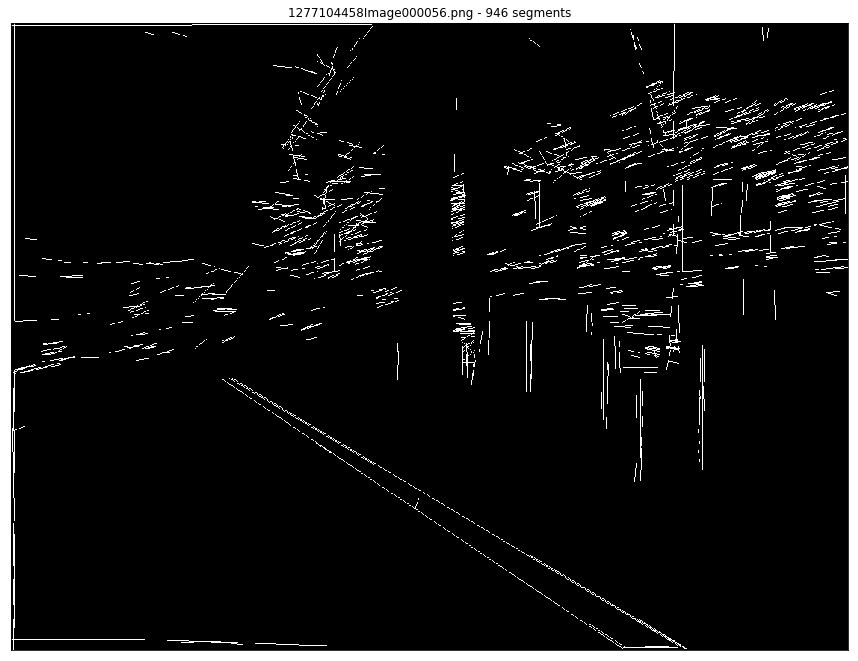

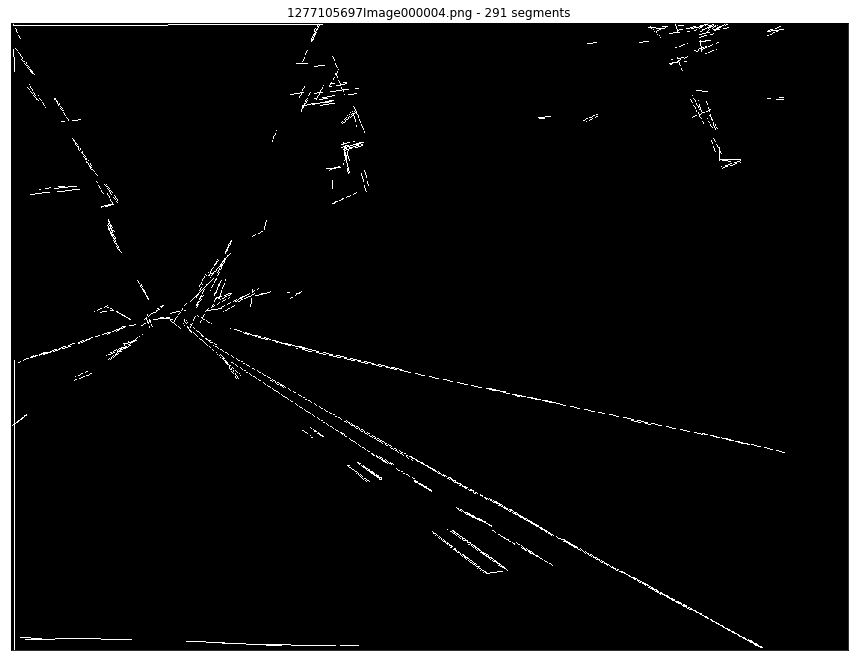

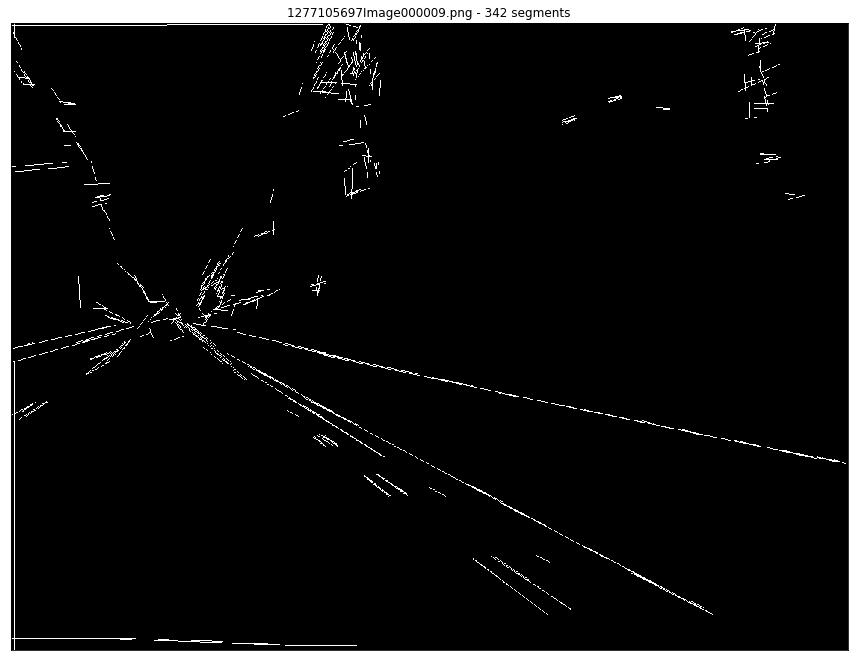

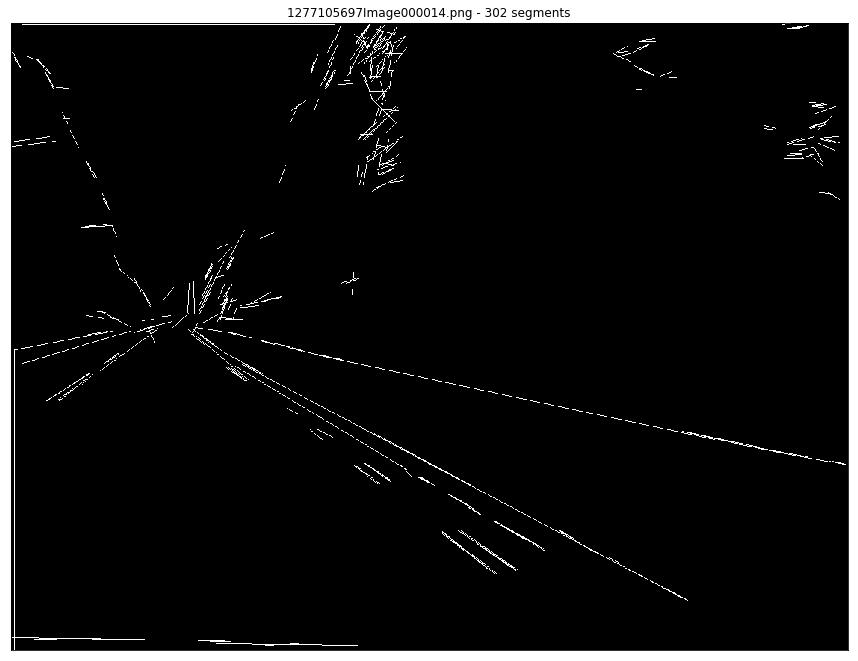

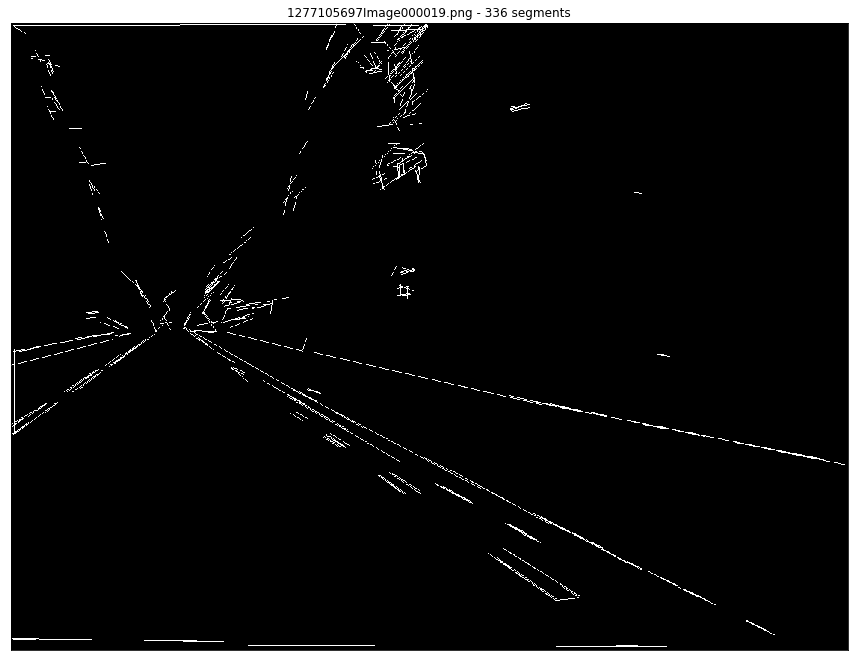

In [18]:
for i in range(10):
    img_edges, lines2, segWithEdge2, seg2 = sd.segHough(road[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{roadNames[i]} - {len(lines2)} segments",seg2)

### 1.5.4. Pcb

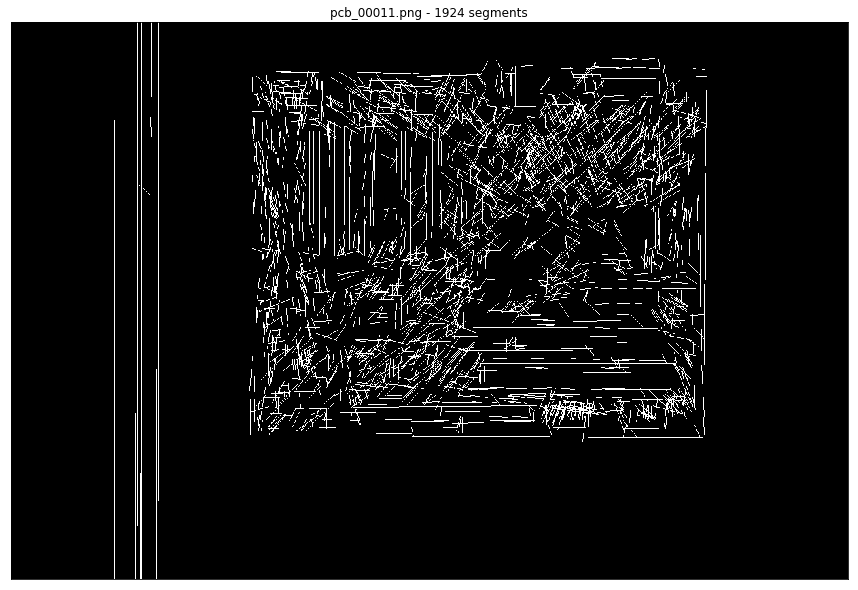

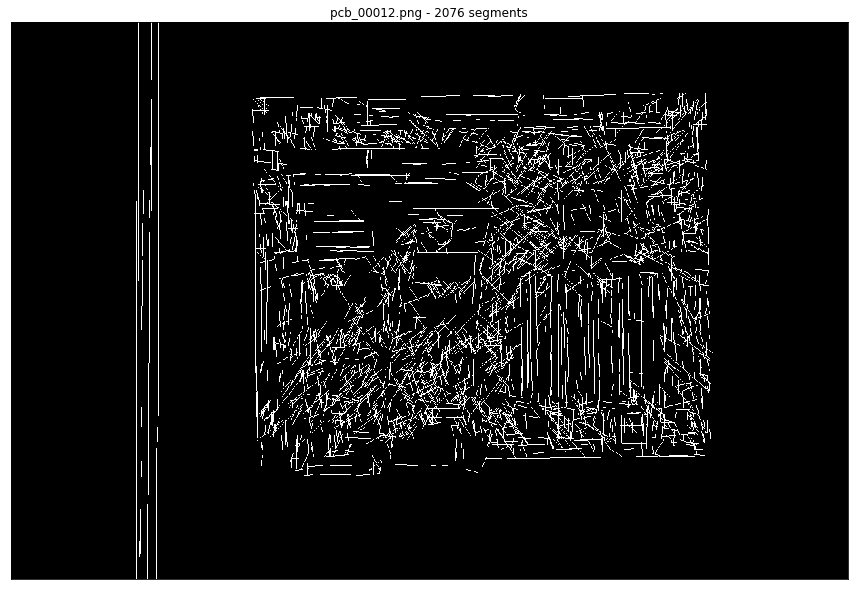

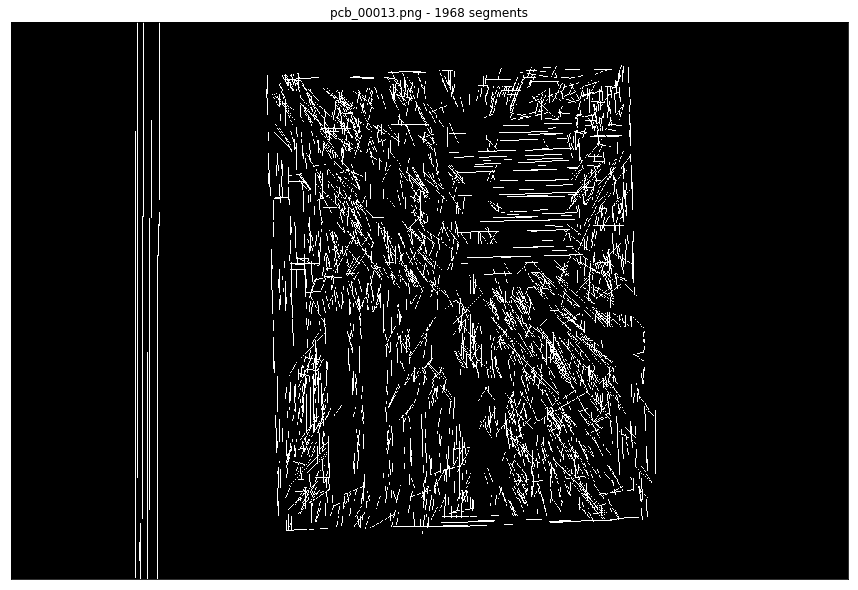

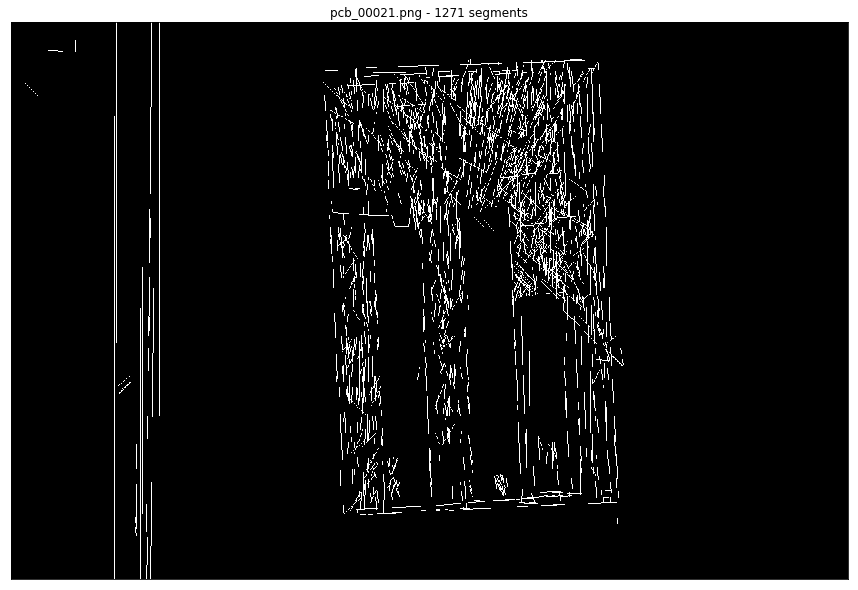

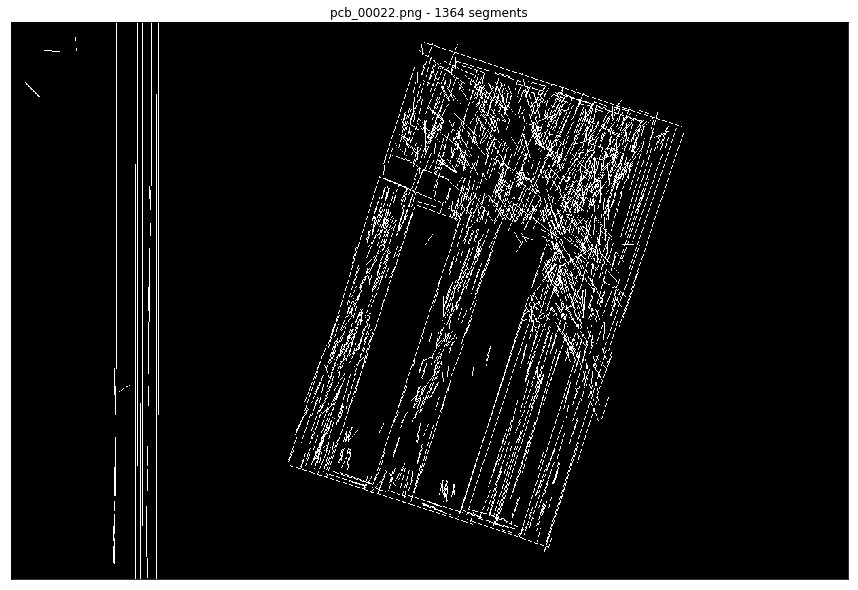

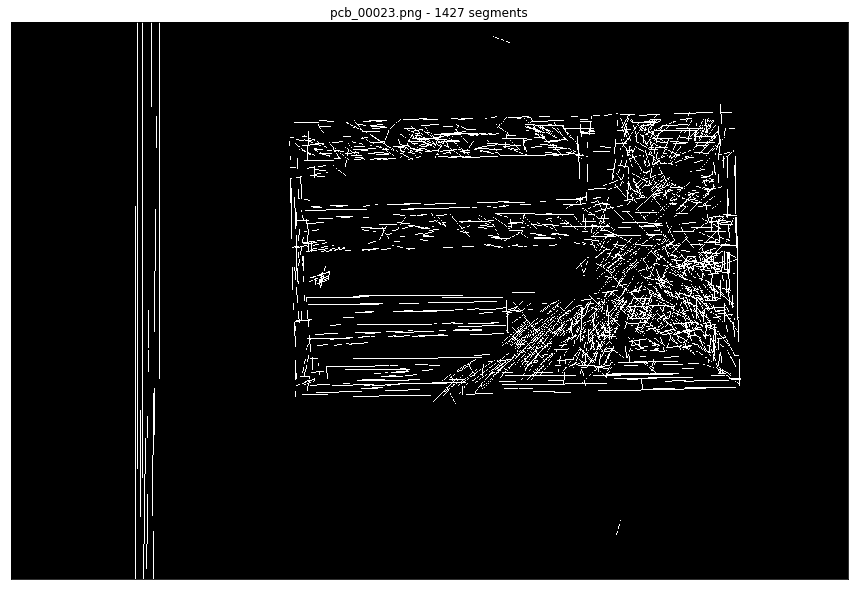

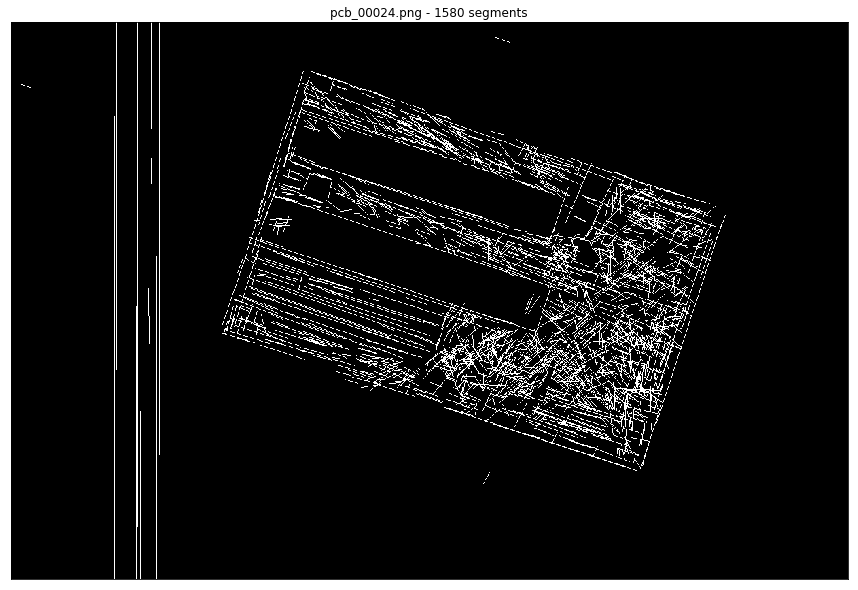

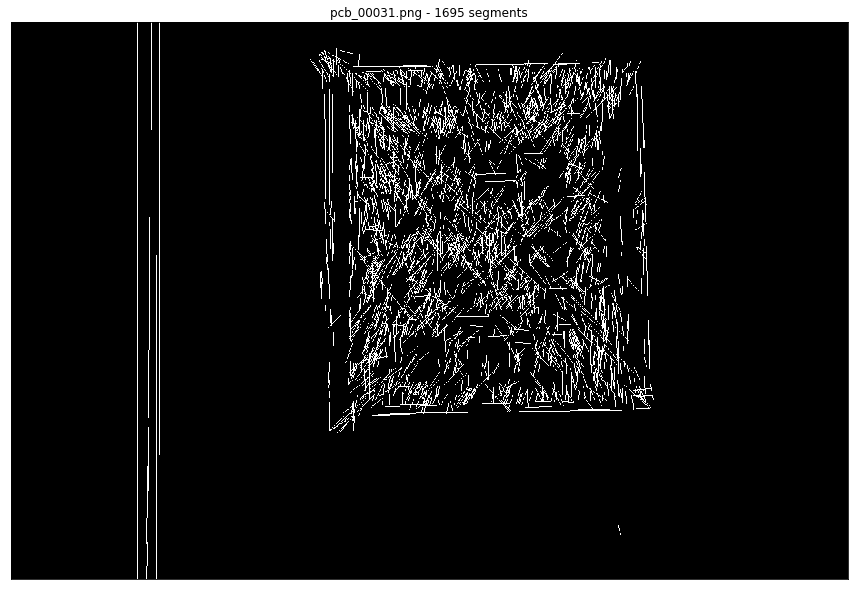

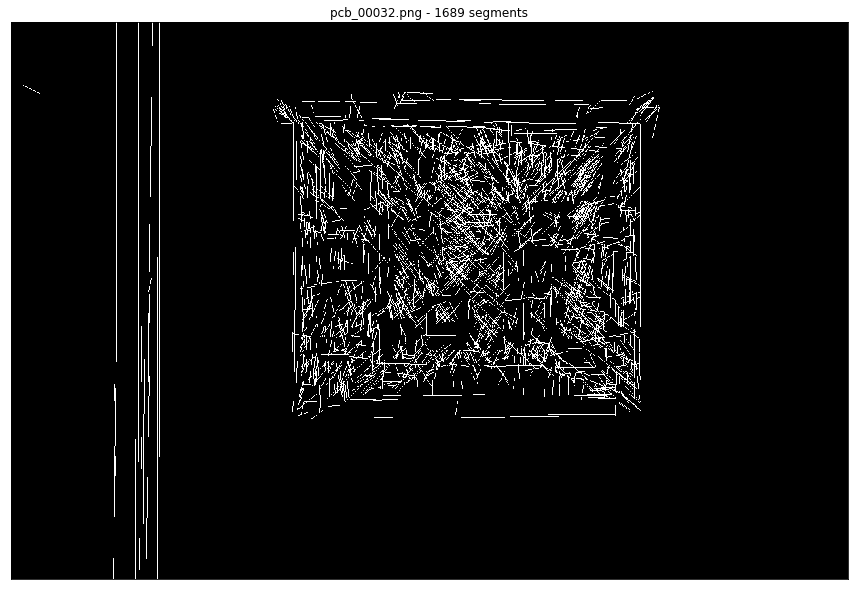

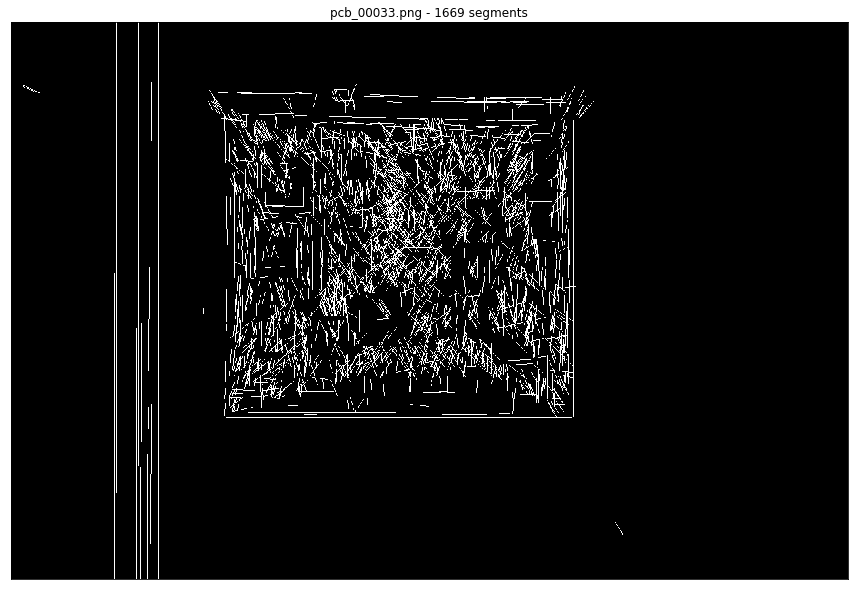

In [19]:
for i in range(10):
    img_edges, lines2, segWithEdge2, seg2 = sd.segHough(pcb[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=2/360*np.pi*2,
                                             dRho = 2)
    display(f"{pcbNames[i]} - {len(lines2)} segments",seg2)

### 1.5.5. Building

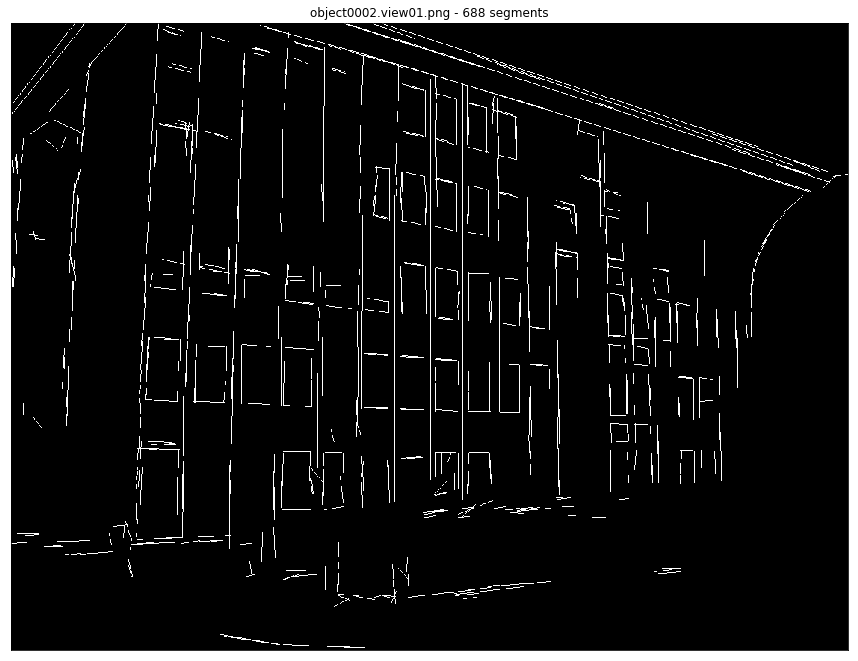

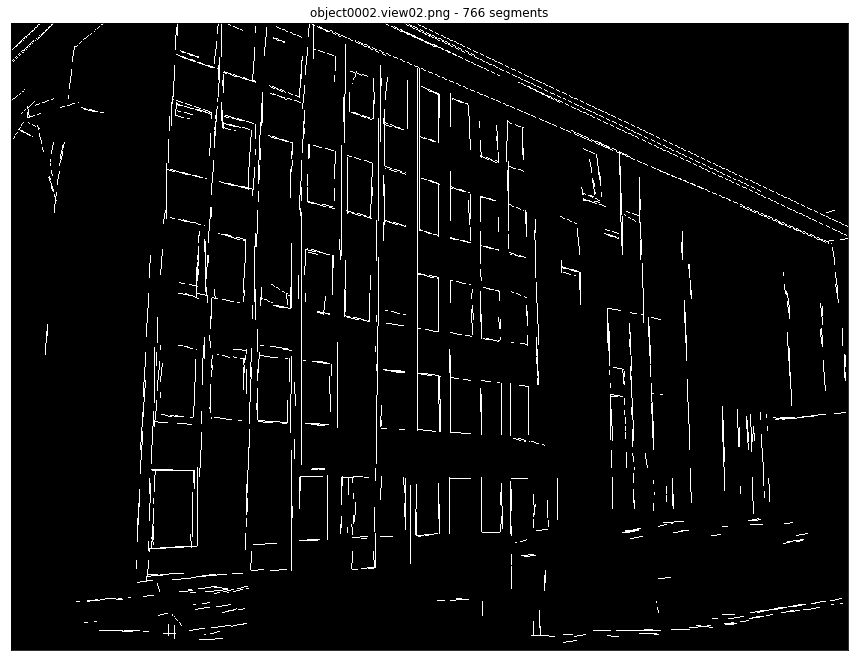

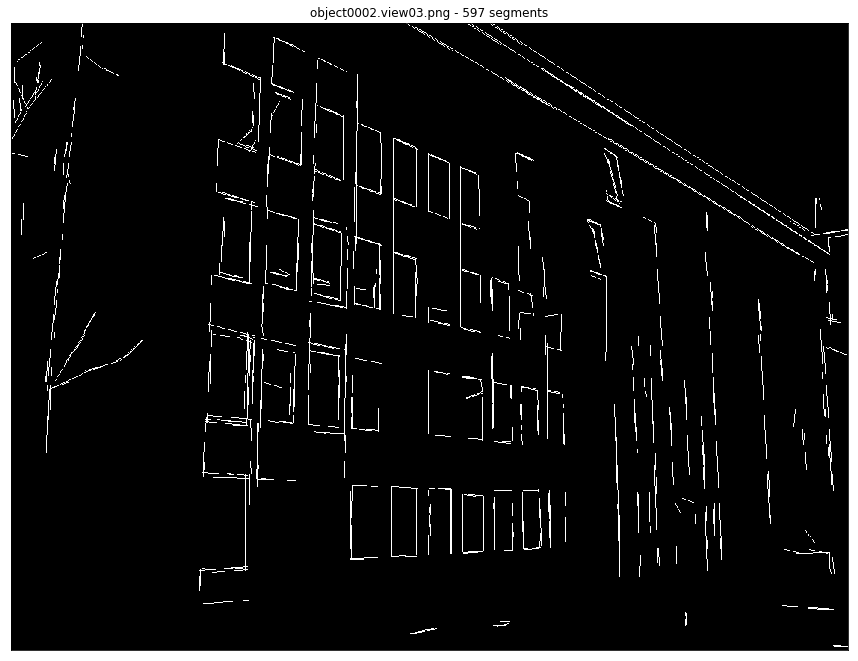

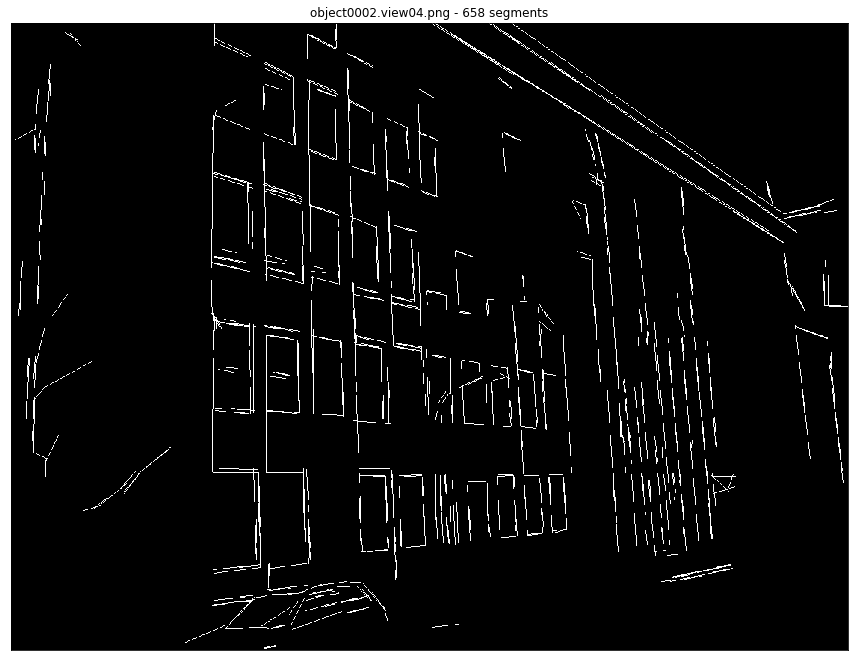

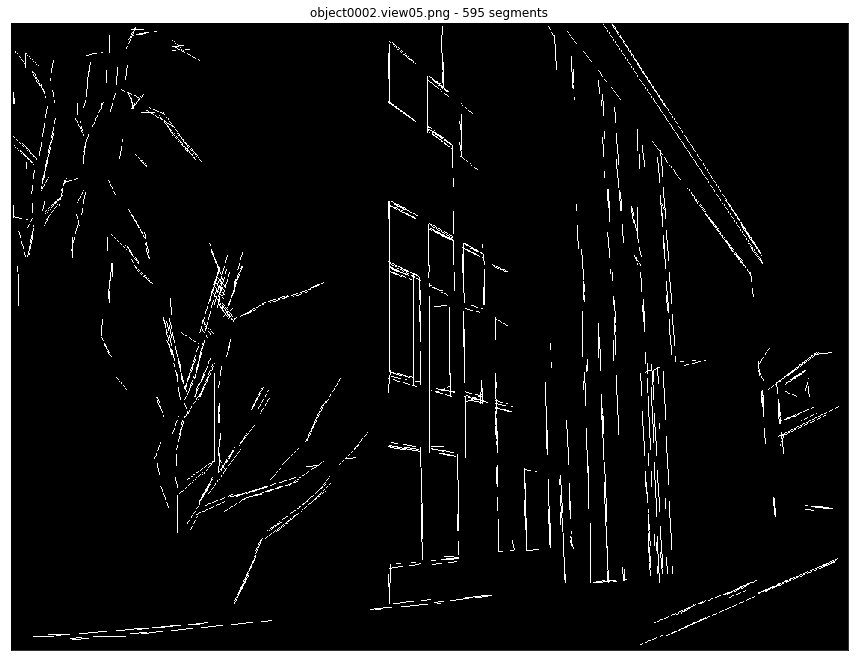

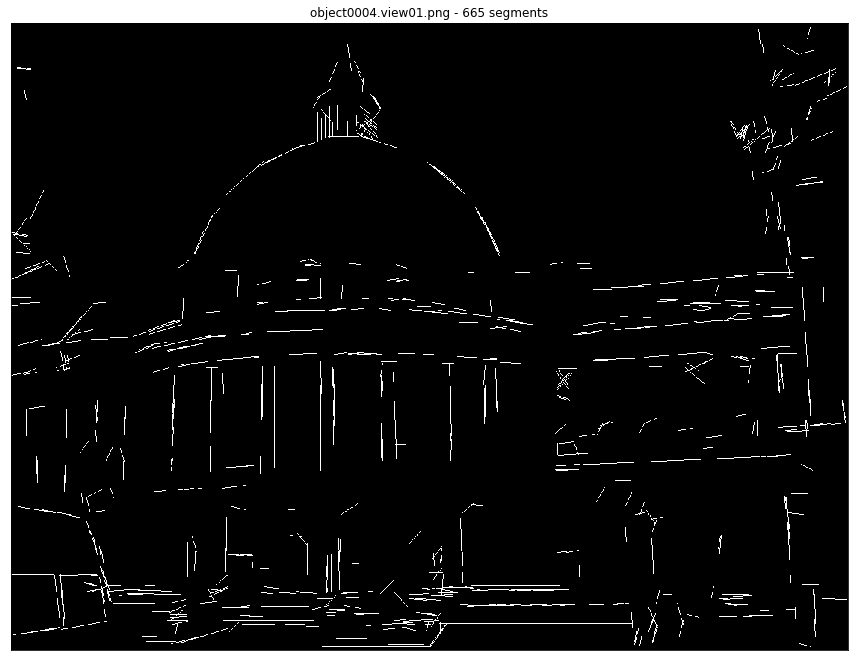

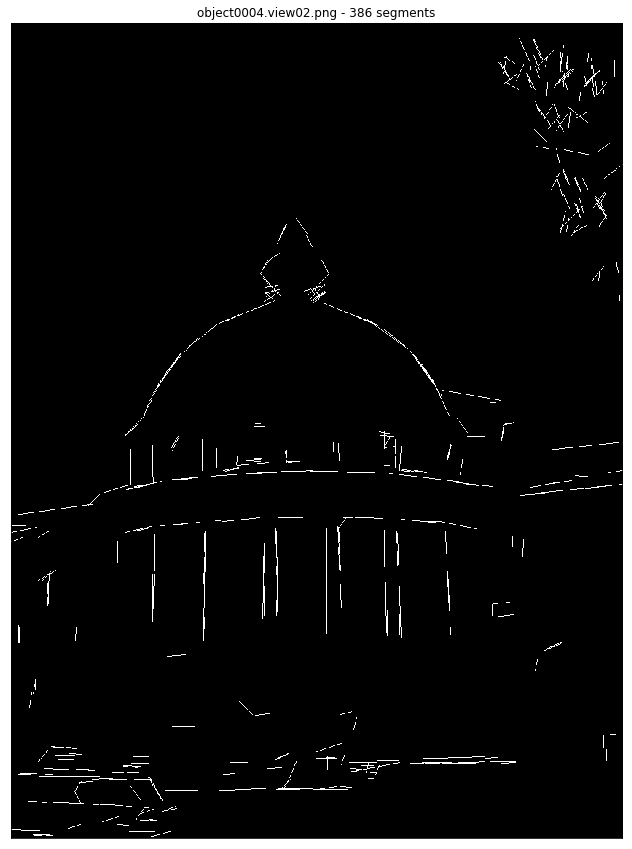

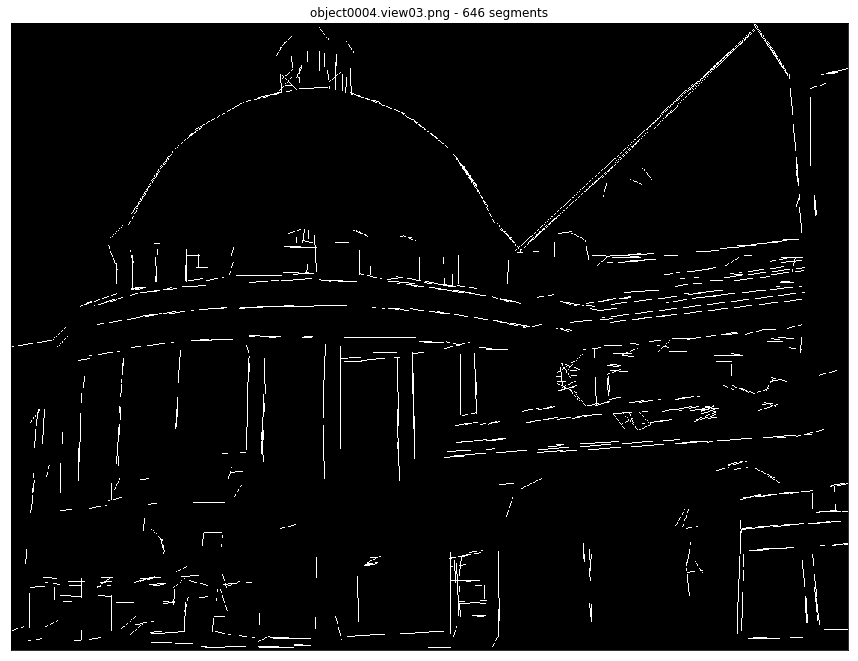

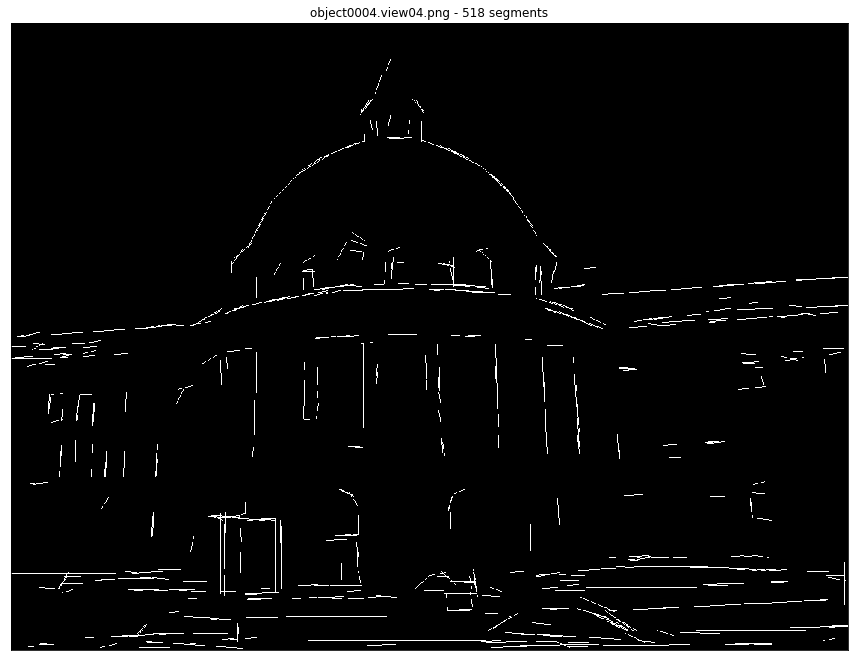

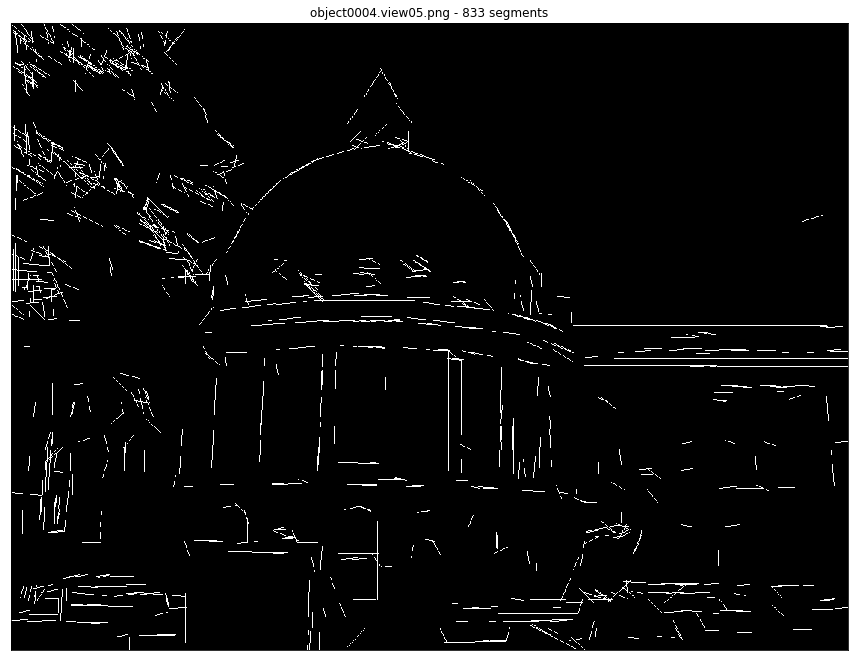

In [20]:
for i in range(10):
    img_edges, lines2, segWithEdge2, seg2 = sd.segHough(building[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{buildingNames[i]} - {len(lines2)} segments",seg2)